In [309]:
import os
import sys
import umap.umap_ as umap

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from gseapy import barplot, dotplot
from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [41]:
import gc
gc.collect()

15650

# Global paths

In [42]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'
result_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/results/'
shift_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/shift_ability/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure7/'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [43]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]

# Data Library

In [44]:
# RS signature infor
RS_sig = pd.read_csv(poseidon_home + 'EC_signatures/all_NREC_REC_gene_info.csv',
                      index_col=0, header=0, sep=',')

In [45]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [46]:
sig_info_tas = sig_info[sig_info['tas'] >= .4]

In [47]:
sig_info_tas

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
sig_id,,,,,,,,,,,,,,,,,,,,,
MET001_N8_XH:BRD-U44432129:100:336,b17,NaN,100.00000,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
ABY001_H1975_XH:BRD-K85606544:10:24,b15,10.00,10.00000,uM,10 uM,24 h,24.0,h,H1975,BRD-K85606544,...,H1975,A15|A19|A23,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:A15|ABY001_H1975_XH_X1_...,NaN,ABY,neratinib,0,0.0,0.0
LUNG001_IMR90_24H:BRD-K88378636:10,b18,10.00,10.00000,uM,10 uM,24 h,24.0,h,IMR90,BRD-K88378636,...,IMR90,G23,LUNG001_IMR90_24H_X2_B18|LUNG001_IMR90_24H_X3_B18,LUNG001_IMR90_24H_X2_B18:G23|LUNG001_IMR90_24H...,NaN,LUNG,withaferin-a,0,0.0,0.0
GMB001_HT29_24H:BRD-A61304759:0.4,b16,0.37,0.40000,uM,0.37 uM,24 h,24.0,h,HT29,BRD-A61304759,...,HT29,F15|M03,GMB001_HT29_24H_X1_B16|GMB001_HT29_24H_X2_B16,GMB001_HT29_24H_X1_B16:F15|GMB001_HT29_24H_X1_...,NaN,GMB,tanespimycin,0,1.0,0.0
PCL001_A375_24H:BRD-K59023263:10,b20,10.00,10.00000,uM,10 uM,24 h,24.0,h,A375,BRD-K59023263,...,A375,I01,PCL001_A375_24H_X1_B20|PCL001_A375_24H_X2_B20|...,PCL001_A375_24H_X1_B20:I01|PCL001_A375_24H_X2_...,NaN,PCL,BRD-K59023263,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL002_MCF7_24H:BRD-K14002526:20,b19,20.00,20.00000,uM,20 uM,24 h,24.0,h,MCF7,BRD-K14002526,...,MCF7,P16,DOSVAL002_MCF7_24H_X1_B19|DOSVAL002_MCF7_24H_X...,DOSVAL002_MCF7_24H_X1_B19:P16|DOSVAL002_MCF7_2...,NaN,DOSVAL,BRD-K14002526,1,1.0,0.0
DOSVAL003_HA1E_24H:BRD-K21680192:20,b19,20.00,20.00000,uM,20 uM,24 h,24.0,h,HA1E,BRD-K21680192,...,HA1E,K07,DOSVAL003_HA1E_24H_X1_B19|DOSVAL003_HA1E_24H_X...,DOSVAL003_HA1E_24H_X1_B19:K07|DOSVAL003_HA1E_2...,NaN,DOSVAL,mitoxantrone,0,1.0,0.0
DOSVAL001_HT29_24H:BRD-K11624501:9.99164,b18,10.00,9.99164,uM,10 uM,24 h,24.0,h,HT29,BRD-K11624501,...,HT29,P16,DOSVAL001_HT29_24H_X1_B18|DOSVAL001_HT29_24H_X...,DOSVAL001_HT29_24H_X1_B18:P16|DOSVAL001_HT29_2...,NaN,DOSVAL,BRD-K11624501,1,1.0,0.0


In [48]:
sig_info_cp = sig_info_tas[sig_info_tas['pert_type'] == 'trt_cp']

In [49]:
sig_info_cp

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
sig_id,,,,,,,,,,,,,,,,,,,,,
MET001_N8_XH:BRD-U44432129:100:336,b17,NaN,100.00000,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
ABY001_H1975_XH:BRD-K85606544:10:24,b15,10.00,10.00000,uM,10 uM,24 h,24.0,h,H1975,BRD-K85606544,...,H1975,A15|A19|A23,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:A15|ABY001_H1975_XH_X1_...,NaN,ABY,neratinib,0,0.0,0.0
LUNG001_IMR90_24H:BRD-K88378636:10,b18,10.00,10.00000,uM,10 uM,24 h,24.0,h,IMR90,BRD-K88378636,...,IMR90,G23,LUNG001_IMR90_24H_X2_B18|LUNG001_IMR90_24H_X3_B18,LUNG001_IMR90_24H_X2_B18:G23|LUNG001_IMR90_24H...,NaN,LUNG,withaferin-a,0,0.0,0.0
GMB001_HT29_24H:BRD-A61304759:0.4,b16,0.37,0.40000,uM,0.37 uM,24 h,24.0,h,HT29,BRD-A61304759,...,HT29,F15|M03,GMB001_HT29_24H_X1_B16|GMB001_HT29_24H_X2_B16,GMB001_HT29_24H_X1_B16:F15|GMB001_HT29_24H_X1_...,NaN,GMB,tanespimycin,0,1.0,0.0
PCL001_A375_24H:BRD-K59023263:10,b20,10.00,10.00000,uM,10 uM,24 h,24.0,h,A375,BRD-K59023263,...,A375,I01,PCL001_A375_24H_X1_B20|PCL001_A375_24H_X2_B20|...,PCL001_A375_24H_X1_B20:I01|PCL001_A375_24H_X2_...,NaN,PCL,BRD-K59023263,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL002_MCF7_24H:BRD-K14002526:20,b19,20.00,20.00000,uM,20 uM,24 h,24.0,h,MCF7,BRD-K14002526,...,MCF7,P16,DOSVAL002_MCF7_24H_X1_B19|DOSVAL002_MCF7_24H_X...,DOSVAL002_MCF7_24H_X1_B19:P16|DOSVAL002_MCF7_2...,NaN,DOSVAL,BRD-K14002526,1,1.0,0.0
DOSVAL003_HA1E_24H:BRD-K21680192:20,b19,20.00,20.00000,uM,20 uM,24 h,24.0,h,HA1E,BRD-K21680192,...,HA1E,K07,DOSVAL003_HA1E_24H_X1_B19|DOSVAL003_HA1E_24H_X...,DOSVAL003_HA1E_24H_X1_B19:K07|DOSVAL003_HA1E_2...,NaN,DOSVAL,mitoxantrone,0,1.0,0.0
DOSVAL001_HT29_24H:BRD-K11624501:9.99164,b18,10.00,9.99164,uM,10 uM,24 h,24.0,h,HT29,BRD-K11624501,...,HT29,P16,DOSVAL001_HT29_24H_X1_B18|DOSVAL001_HT29_24H_X...,DOSVAL001_HT29_24H_X1_B18:P16|DOSVAL001_HT29_2...,NaN,DOSVAL,BRD-K11624501,1,1.0,0.0


In [50]:
shRNA_cancer = ['BRCA', 'CRC', 'LIHC', 'LUNG', 'PRAD', 'SKCM']
compound_cancer = ['BLCA', 'BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG',
                   'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'UCEC']


# read the shRNA enrichment results
shRNA_result = {}
for ct in shRNA_cancer:
    shRNA_result[ct] = pd.read_csv(shift_home + ct + '_trt_sh.csv',
                                   sep=',', index_col=0)
    shRNA_result[ct]['cancer_type'] = ct
    print(ct, shRNA_result[ct].shape)
    
# read the compound enrichment results
compound_result = {}
for ct in compound_cancer:
    compound_result[ct] = pd.read_csv(shift_home + ct + '_trt_cp.csv',
                                   sep=',', index_col=0)
    compound_result[ct]['cancer_type'] = ct
    print(ct, compound_result[ct].shape)

BRCA (2060, 7)
CRC (1317, 7)
LIHC (1437, 7)
LUNG (2828, 7)
PRAD (3923, 7)
SKCM (2384, 7)
BLCA (5, 7)
BRCA (9573, 7)
CESC (2906, 7)
CRC (4516, 7)
LIHC (2361, 7)
LUNG (6901, 7)
OV (53, 7)
PAAD (1906, 7)
PRAD (8107, 7)
SKCM (4917, 7)
STAD (38, 7)
UCEC (38, 7)


In [51]:
# merge the results into the matrix
merged_shRNA = pd.concat([shRNA_result[d] for d in shRNA_result.keys()], axis=0)
merged_compound = pd.concat([compound_result[d] for d in compound_result.keys()], axis=0)

# PAK4 on GO terms

In [20]:
def case_gsea_compound_immune(drug_name, shift_result):
    # initialize
    gsea_result = {}
    
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    
    # get the GSEA
    for s in tmp_sig.index:
        p_rename = '__'.join(s.split(':'))
        rnk = pd.read_csv(gsea_home + shift_result.loc[s, 'cancer_type'] + '/trt_cp/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets='GO_Biological_Process_2021',
                             threads=20,
                             permutation_num=100,
                             outdir=None, seed=0, min_size=10, max_size=2000)
        gsea_result[s] = pre_res.res2d
        
    return gsea_result

In [14]:
sig_dox = merged_compound[merged_compound['cmap_name'] == 'doxorubicin']

In [15]:
sig_dox

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type
REP.A026_MCF7_24H:L24,-0.391305,0.463676,doxorubicin,0.04,0.04 uM,0.854981,BRCA
LKCP002_MCF7_24H:I23,-0.411189,0.429526,doxorubicin,1.11,1.11 uM,0.840715,BRCA
LKCP002_MCF7_48H:I23,-0.383560,0.451692,doxorubicin,1.11,1.11 uM,0.835252,BRCA
REP.A026_MCF7_24H:L22,-0.443742,0.388550,doxorubicin,0.37,0.37 uM,0.832292,BRCA
LKCP002_MCF7_24H:I24,-0.394295,0.423689,doxorubicin,0.12,0.12 uM,0.817984,BRCA
...,...,...,...,...,...,...,...
REP.A026_A375_24H:L19,-0.355292,0.339953,doxorubicin,10.00,10 uM,0.695246,SKCM
REP.A026_A375_24H:L21,-0.391330,0.302051,doxorubicin,1.11,1.11 uM,0.693381,SKCM
CPC005_A375_6H:BRD-A76941896-003-02-0:10,-0.314243,0.375235,doxorubicin,10.00,10 uM,0.689478,SKCM
CPC018_A375_6H:BRD-A52530684-001-01-1:10,-0.310118,0.377599,doxorubicin,10.00,10 uM,0.687717,SKCM


In [22]:
case_dox = case_gsea_compound_immune(drug_name='doxorubicin', shift_result=sig_dox)

2023-05-23 19:14:37,557 [WARNING] Duplicated values found in preranked stats: 4.30% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:14:43,723 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:14:50,002 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:14:55,833 [WARNING] Duplicated values found in preranked stats: 3.52% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:15:01,921 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:15:08,961 [WARNING] Duplicated values found in preranked stats: 4.49% of genes
The order of those genes will be

2023-05-23 19:19:32,138 [WARNING] Duplicated values found in preranked stats: 3.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:19:38,886 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:19:44,966 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:19:50,960 [WARNING] Duplicated values found in preranked stats: 3.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:20:02,772 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:20:08,872 [WARNING] Duplicated values found in preranked stats: 2.88% of genes
The order of those genes will be

2023-05-23 19:24:35,938 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:24:48,668 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:24:54,891 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:25:00,962 [WARNING] Duplicated values found in preranked stats: 0.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:25:06,985 [WARNING] Duplicated values found in preranked stats: 2.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:25:13,236 [WARNING] Duplicated values found in preranked stats: 0.32% of genes
The order of those genes will be

2023-05-23 19:29:51,496 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:29:57,726 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:30:04,201 [WARNING] Duplicated values found in preranked stats: 3.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:30:11,467 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:30:17,656 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-23 19:30:23,779 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be

In [36]:
dox_go_nes = pd.concat([df(case_dox[k].set_index('Term')['NES']).rename(columns={'NES': k}) for k in case_dox.keys()], axis=1)

In [37]:
dox_go_nes

,REP.A026_MCF7_24H:L24,LKCP002_MCF7_24H:I23,LKCP002_MCF7_48H:I23,REP.A026_MCF7_24H:L22,LKCP002_MCF7_24H:I24,REP.B026_MCF7_24H:L23,PBIOA018_MCF7_24H:O12,REP.A026_MCF7_24H:L20,LKCP002_MCF7_6H:I23,REP.B026_MCF7_24H:L22,...,PCLB003_A375_24H:BRD-A52530684-003-01-7:0.04,PCLB003_A375_24H:BRD-A52530684-003-01-7:0.12,PCLB003_A375_24H:BRD-A52530684-003-01-7:10,REP.A026_A375_24H:L23,PCLB003_A375_24H:BRD-A52530684-003-01-7:1.11,REP.A026_A375_24H:L19,REP.A026_A375_24H:L21,CPC005_A375_6H:BRD-A76941896-003-02-0:10,CPC018_A375_6H:BRD-A52530684-001-01-1:10,REP.A026_A375_24H:L20
mitotic spindle organization (GO:0007052),-2.80222,-3.04564,-3.24683,-2.77983,-2.97737,-2.84166,-3.13319,-2.93405,-3.05351,-3.08836,...,-3.36175,-3.17598,-2.60886,-3.27287,-2.73856,-2.45678,-2.80525,-1.49097,-1.95807,-2.60776
mitotic sister chromatid segregation (GO:0000070),-2.79309,-2.63948,-2.67231,-2.51688,-2.90769,-2.80023,-2.85664,-2.17603,-2.57895,-3.11865,...,-2.83683,-2.59459,-2.15368,-2.9381,-2.82078,-2.17667,-2.49573,-1.40215,-1.98877,-2.42163
microtubule cytoskeleton organization involved in mitosis (GO:1902850),-2.73476,-3.09966,-3.1439,-2.67727,-2.91569,-2.81156,-3.21323,-2.73791,-2.99801,-3.18217,...,-3.27989,-3.11304,-2.64143,-3.17605,-2.7624,-2.60226,-2.46253,-1.70133,-2.33711,-2.54671
cellular macromolecule biosynthetic process (GO:0034645),-2.66683,-3.3404,-3.024,-2.83677,-2.79154,-2.09315,-2.57616,-3.14602,-1.35204,-2.94167,...,-2.21381,-2.27448,-1.96574,-2.69424,-2.47627,-2.10207,-2.74721,-1.47699,-1.52228,-2.86915
DNA metabolic process (GO:0006259),-2.65169,-3.01702,-2.74808,-2.81678,-3.01824,-2.92134,-2.77612,-2.57387,-1.90754,-3.19391,...,-2.4224,-2.5862,-1.70046,-2.82709,-2.10212,-1.71249,-1.76217,-1.23215,-1.52686,-1.89279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3'-phosphoadenosine 5'-phosphosulfate metabolic process (GO:0050427),-0.419483,1.09359,0.801425,0.856978,0.96816,0.93748,1.53018,0.460586,-0.499564,1.54796,...,0.814274,-0.907254,0.691819,0.435669,0.526323,1.17446,0.614381,1.75885,1.40109,0.683879
regulation of Arp2/3 complex-mediated actin nucleation (GO:0034315),0.417908,-0.811255,-1.10567,1.04165,0.940052,-0.913106,0.586741,-1.10013,-0.623317,0.807896,...,0.834771,0.789343,-1.12672,0.820779,-0.621492,-1.09968,-1.13336,0.818482,1.00923,-1.32471
positive regulation of leukocyte mediated cytotoxicity (GO:0001912),0.417151,1.93968,1.85859,1.21064,0.926995,0.37702,1.35928,1.91203,1.95905,1.20044,...,1.36231,1.44167,1.31788,0.518462,1.17619,1.85063,1.00615,1.08143,1.21165,1.72345
oligodendrocyte development (GO:0014003),-0.411344,-1.08789,-1.12804,-0.916194,-0.778937,-0.604243,0.838395,-1.59943,-1.16288,0.569951,...,0.861504,-0.941918,-1.60978,1.1344,-1.009,-1.44284,-0.782376,-0.699737,-0.54384,-1.21843


<AxesSubplot:xlabel='autophagy of mitochondrion (GO:0000422)', ylabel='Density'>

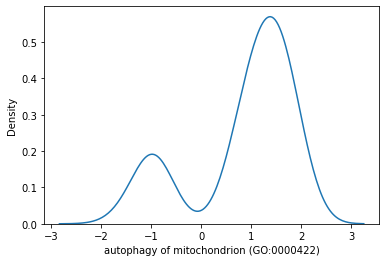

In [38]:
sns.kdeplot(dox_go_nes.loc['autophagy of mitochondrion (GO:0000422)', :])

<AxesSubplot:xlabel='type I interferon signaling pathway (GO:0060337)', ylabel='Density'>

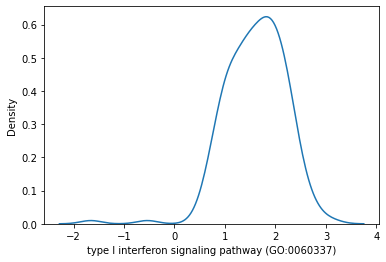

In [39]:
sns.kdeplot(dox_go_nes.loc['type I interferon signaling pathway (GO:0060337)', :])

In [22]:
sig_pak4 = merged_compound[merged_compound['cmap_name'] == 'PF-03758309']

In [23]:
sig_pak4

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type
REP.A014_MCF7_24H:K17,-0.395146,0.395726,PF-03758309,0.125,0.125 uM,0.790873,BRCA
REP.A014_MCF7_24H:K15,-0.361099,0.288309,PF-03758309,1.110,1.11 uM,0.649409,BRCA
REP.B014_MCF7_24H:K13,-0.266355,0.308703,PF-03758309,2.220,2.22 uM,0.575058,BRCA
REP.B014_MCF7_24H:K16,-0.265991,0.307735,PF-03758309,0.080,0.08 uM,0.573726,BRCA
REP.A014_MCF7_24H:K13,-0.298327,0.273402,PF-03758309,10.000,10 uM,0.571729,BRCA
...,...,...,...,...,...,...,...
REP.A014_A375_24H:K16,-0.251660,0.292566,PF-03758309,0.370,0.37 uM,0.544226,SKCM
REP.B014_A375_24H:K15,-0.216803,0.282341,PF-03758309,0.250,0.25 uM,0.499144,SKCM
LJP009_A375_24H:D03,-0.320887,0.149351,PF-03758309,1.110,1.11 uM,0.470238,SKCM
REP.A014_A375_24H:K17,-0.233447,0.208398,PF-03758309,0.125,0.125 uM,0.441845,SKCM


In [24]:
case_pak4i = case_gsea_compound_immune(drug_name='PF-03758309', shift_result=sig_pak4)

In [25]:
pak4i_go_nes = pd.concat([df(case_pak4i[k]['nes']).rename(columns={'nes': k}) for k in case_pak4i.keys()], axis=1)

In [31]:
pak4i_go_fdr = pd.concat([df(case_pak4i[k]['fdr']).rename(columns={'fdr': k}) for k in case_pak4i.keys()], axis=1)

In [26]:
pak4i_go_nes

,REP.A014_MCF7_24H:K17,REP.A014_MCF7_24H:K15,REP.B014_MCF7_24H:K13,REP.B014_MCF7_24H:K16,REP.A014_MCF7_24H:K13,LJP009_MCF7_24H:D02,REP.A014_MCF7_24H:K18,REP.B014_MCF7_24H:K14,REP.A014_MCF7_24H:K16,REP.A014_MCF7_24H:K14,...,REP.A014_A375_24H:K13,MOAR004_A375_24H:A16,REP.A014_A375_24H:K14,REP.B014_A375_24H:K13,REP.B014_A375_24H:K14,REP.A014_A375_24H:K16,REP.B014_A375_24H:K15,LJP009_A375_24H:D03,REP.A014_A375_24H:K17,REP.A014_A375_24H:K15
DNA metabolic process (GO:0006259),-2.425623,-2.838303,-2.350295,-2.350486,-2.444339,-2.313731,-2.029687,-2.471644,-2.703848,-2.270467,...,-2.719522,-2.804958,-2.453705,-1.754418,-2.222824,-1.689457,-1.435689,-2.344256,-1.390633,-1.943348
DNA replication (GO:0006260),-2.576129,-2.905969,-2.476623,-2.188192,-2.932910,-2.450863,-1.644279,-2.702433,-2.686077,-2.363740,...,-2.912479,-3.263063,-2.601091,-1.770323,-1.859409,-1.700183,-1.062246,-2.945049,-1.072018,-1.971040
DNA replication initiation (GO:0006270),-2.529517,-2.870223,-2.529106,-2.324000,-2.466338,-2.575589,-2.086392,-2.980082,-2.624281,-2.398980,...,-2.690535,-2.912074,-2.470347,-2.369232,-2.841313,-2.112364,-1.534130,-2.364722,-1.503838,-2.470886
DNA strand elongation involved in DNA replication (GO:0006271),-2.459969,-2.690107,-2.295258,-1.977535,-2.352720,-2.515805,-1.844008,-2.319391,-2.475124,-2.103892,...,-2.330238,-2.646582,-2.393154,-1.948497,-1.819133,-1.918226,-1.571394,-2.213950,-1.281240,-2.174036
DNA-dependent DNA replication (GO:0006261),-2.663202,-2.716992,-2.397036,-2.065976,-2.623566,-2.562770,-1.422467,-2.397083,-2.469750,-2.232939,...,-2.724170,-2.947924,-2.565218,-2.080722,-2.503647,-1.658124,-1.054756,-3.209625,-1.185760,-2.067204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
positive regulation of receptor-mediated endocytosis (GO:0048260),0.479685,0.558867,0.819438,1.541002,1.223586,-1.123137,-1.278224,0.604609,1.070691,0.738907,...,0.606041,0.764369,-0.547160,-1.291030,1.030013,-1.460869,-1.448394,1.406699,-1.217630,-0.834453
positive regulation of synapse assembly (GO:0051965),-0.605074,0.747456,0.646253,0.906617,1.552784,0.714535,0.920203,-1.012100,-0.769885,-0.679567,...,-0.665137,1.150932,-0.811472,-1.480693,1.273159,-0.633660,-1.516166,0.847576,-1.110032,-1.467177
regulation of phosphatase activity (GO:0010921),-0.582738,1.153765,0.666477,0.716995,0.894793,0.705476,-0.925494,0.970831,1.366762,0.942107,...,0.756612,1.252806,0.825732,-1.163828,0.953011,-0.856684,-1.576541,0.657647,-0.740873,-0.846232
regulation of protein transport (GO:0051223),-0.576549,1.433894,1.311832,1.228791,-0.891371,1.450342,1.113218,1.492704,1.602588,1.457122,...,0.577368,0.801016,0.938913,-1.486592,-2.010465,1.476788,-1.168814,-0.799506,-0.901883,-1.419569


<AxesSubplot:xlabel='autophagy of mitochondrion (GO:0000422)', ylabel='Density'>

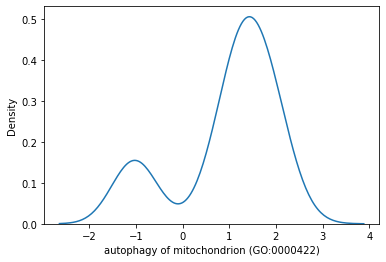

In [28]:
sns.kdeplot(pak4i_go_nes.loc['autophagy of mitochondrion (GO:0000422)', :])

In [72]:
pak4i_go_nes.loc['autophagy of mitochondrion (GO:0000422)', :].mean()

0.9811886595879916

<AxesSubplot:xlabel='type I interferon signaling pathway (GO:0060337)', ylabel='Density'>

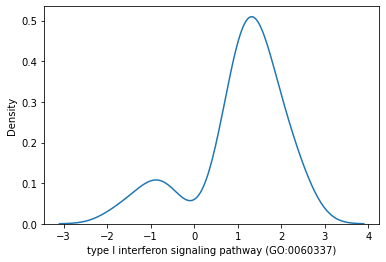

In [30]:
sns.kdeplot(pak4i_go_nes.loc['type I interferon signaling pathway (GO:0060337)', :])

In [37]:
pak4i_go_log10fdr = -np.log10(pak4i_go_fdr + 0.0001)
pak4i_go_log10fdr = pak4i_go_log10fdr[pak4i_go_log10fdr >=0 ].fillna(0)

In [41]:
sig_pak4['cell_line'] = sig_info_cp['cell_iname']

<ipython-input-41-895349a281b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_pak4['cell_line'] = sig_info_cp['cell_iname']


In [42]:
sig_pak4

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line
REP.A014_MCF7_24H:K17,-0.395146,0.395726,PF-03758309,0.125,0.125 uM,0.790873,BRCA,MCF7
REP.A014_MCF7_24H:K15,-0.361099,0.288309,PF-03758309,1.110,1.11 uM,0.649409,BRCA,MCF7
REP.B014_MCF7_24H:K13,-0.266355,0.308703,PF-03758309,2.220,2.22 uM,0.575058,BRCA,MCF7
REP.B014_MCF7_24H:K16,-0.265991,0.307735,PF-03758309,0.080,0.08 uM,0.573726,BRCA,MCF7
REP.A014_MCF7_24H:K13,-0.298327,0.273402,PF-03758309,10.000,10 uM,0.571729,BRCA,MCF7
...,...,...,...,...,...,...,...,...
REP.A014_A375_24H:K16,-0.251660,0.292566,PF-03758309,0.370,0.37 uM,0.544226,SKCM,A375
REP.B014_A375_24H:K15,-0.216803,0.282341,PF-03758309,0.250,0.25 uM,0.499144,SKCM,A375
LJP009_A375_24H:D03,-0.320887,0.149351,PF-03758309,1.110,1.11 uM,0.470238,SKCM,A375
REP.A014_A375_24H:K17,-0.233447,0.208398,PF-03758309,0.125,0.125 uM,0.441845,SKCM,A375


In [129]:
sig_pak4_r2s = sig_pak4[sig_pak4['shift_ability'] >= .7]

In [156]:
sig_pak4_r2s['cell_line'].value_counts()

PC3       8
A375      4
HT29      3
YAPC      2
HCC515    1
MCF7      1
Name: cell_line, dtype: int64

In [192]:
# group by cell line (only r2s)
pak4i_go_grouped_r2s = pak4i_go_nes[sig_pak4_r2s.index].copy().T
pak4i_go_grouped_r2s['cell_line'] = sig_pak4['cell_line']
pak4i_go_grouped_r2s = pak4i_go_grouped_r2s.groupby('cell_line').mean()
pak4i_go_grouped_r2s = pak4i_go_grouped_r2s.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

pak4i_go_grouped_r2s_fdr = pak4i_go_log10fdr[sig_pak4_r2s.index].copy().T
pak4i_go_grouped_r2s_fdr['cell_line'] = sig_pak4['cell_line']
pak4i_go_grouped_r2s_fdr = pak4i_go_grouped_r2s_fdr.groupby('cell_line').mean()
pak4i_go_grouped_r2s_fdr = pak4i_go_grouped_r2s_fdr.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


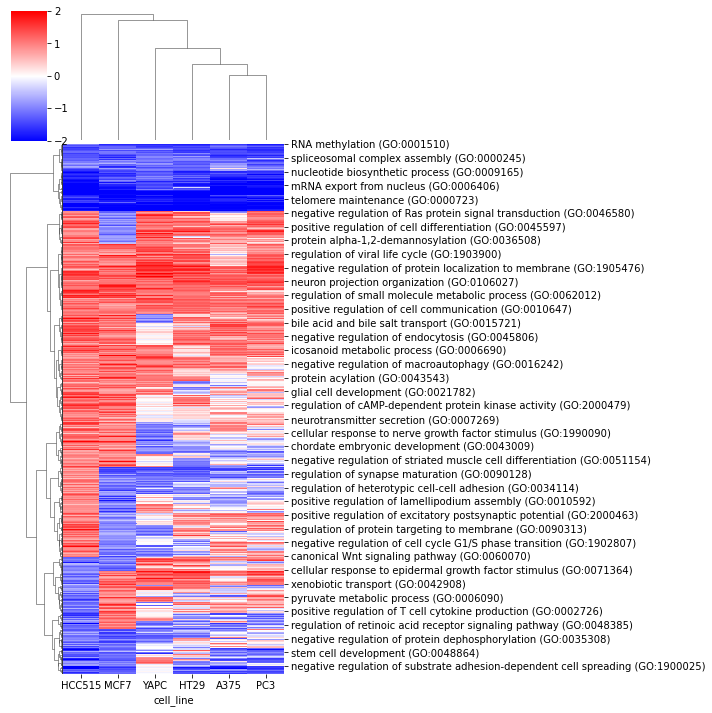

In [145]:
sns.clustermap(pak4i_go_grouped_r2s.T,
               method='ward',
               cmap='bwr', vmin=-2., vmax=2.)

In [160]:
top15 = df(pak4i_go_grouped_r2s.mean()).sort_values(by=0, ascending=False)[:15]

In [182]:
bottom15 = df(pak4i_go_grouped_r2s.mean()).sort_values(by=0, ascending=False)[-15:]

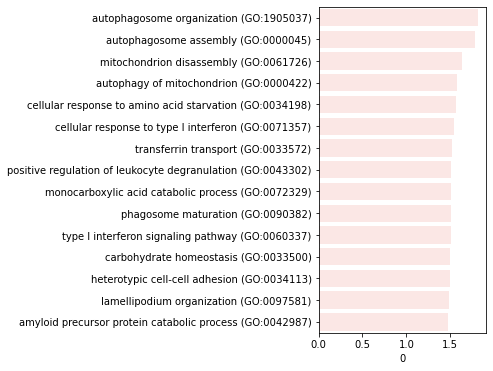

In [216]:
plt.figure(figsize=(3, 6))
sns.barplot(x=top15[0], y=top15.index, color='mistyrose')
fig = plt.gcf()
fig.savefig(panel_home + 'top15_sorted.pdf', transparent=True)

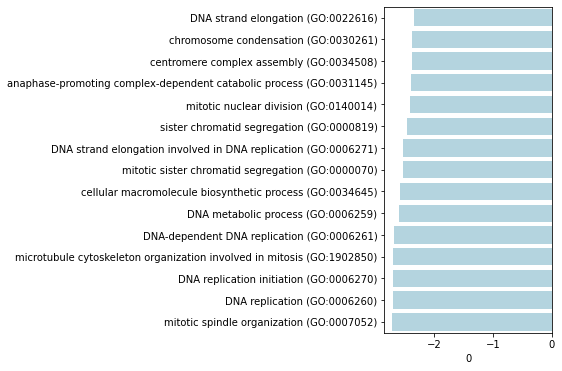

In [217]:
plt.figure(figsize=(3, 6))
sns.barplot(x=bottom15[0], y=bottom15.index, color='lightblue')
fig = plt.gcf()
fig.savefig(panel_home + 'bottom15_sorted.pdf', transparent=True)

<AxesSubplot:xlabel='cell_line'>

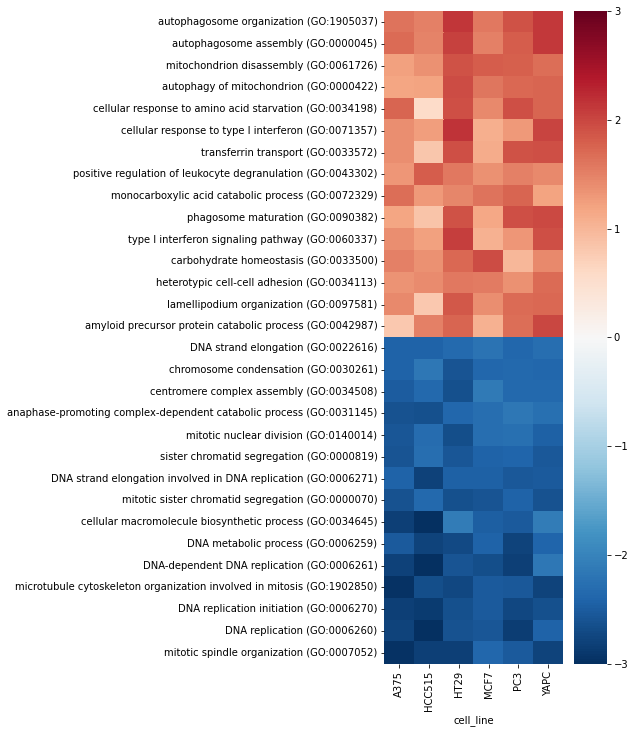

In [191]:
case_list = list(top15.index)
case_list.extend(list(bottom15.index))
plt.figure(figsize=(4, 12))
sns.heatmap(pak4i_go_grouped_r2s[case_list].T, cmap='RdBu_r', vmin=-3, vmax=3)

In [194]:
pak4i_go_grouped_r2s_fdr[case_list]

,autophagosome organization (GO:1905037),autophagosome assembly (GO:0000045),mitochondrion disassembly (GO:0061726),autophagy of mitochondrion (GO:0000422),cellular response to amino acid starvation (GO:0034198),cellular response to type I interferon (GO:0071357),transferrin transport (GO:0033572),positive regulation of leukocyte degranulation (GO:0043302),monocarboxylic acid catabolic process (GO:0072329),phagosome maturation (GO:0090382),...,sister chromatid segregation (GO:0000819),DNA strand elongation involved in DNA replication (GO:0006271),mitotic sister chromatid segregation (GO:0000070),cellular macromolecule biosynthetic process (GO:0034645),DNA metabolic process (GO:0006259),DNA-dependent DNA replication (GO:0006261),microtubule cytoskeleton organization involved in mitosis (GO:1902850),DNA replication initiation (GO:0006270),DNA replication (GO:0006260),mitotic spindle organization (GO:0007052)
cell_line,,,,,,,,,,,,,,,,,,,,,
A375,0.573345,0.686789,0.276158,0.279530,0.744269,0.317233,0.298103,0.271382,0.766489,0.181707,...,4.000000,3.868745,4.000000,3.579091,3.848515,4.000000,4.000000,4.0,4.000000,4.000000
HCC515,0.496552,0.478587,0.381647,0.259604,0.002952,0.288377,0.047720,0.925671,0.320965,0.052796,...,2.945397,4.000000,3.303390,4.000000,4.000000,4.000000,3.315112,4.0,4.000000,4.000000
HT29,2.193635,2.242090,2.082476,2.089896,1.199996,1.852808,1.833209,0.580644,0.455875,1.151780,...,4.000000,4.000000,4.000000,2.932542,4.000000,4.000000,4.000000,4.0,4.000000,4.000000
MCF7,0.455601,0.438220,0.722022,0.454586,0.420029,0.173438,0.178978,0.340895,0.453046,0.209644,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000
PC3,1.552583,1.394181,1.123670,0.966424,1.303968,0.397352,1.199967,0.597374,0.910029,1.703778,...,3.894353,3.925093,3.614897,3.883081,4.000000,4.000000,3.789528,4.0,4.000000,3.775128
YAPC,1.543423,2.529526,0.845034,0.918192,0.880822,1.333138,1.408644,0.428589,0.256562,1.287235,...,4.000000,4.000000,4.000000,3.017940,3.651851,3.017232,4.000000,4.0,3.034099,4.000000


In [204]:
def boPlot(corr, fdr, fdr_threshold, vmin, vmax, size_adjuster, path=None):
    '''
    Visualize by bo plot for infiltration. Dot size indicate the significance, color indicate the correlation
    '''
    location = {}
    j = 1
    for ctype in fdr.columns:
        location[ctype] = df(index=fdr.index, columns=['x', 'y'])
        location[ctype]['fdr'] = fdr[ctype]
        location[ctype]['corr'] = corr[ctype]

        i = 1
        for t in location[ctype].index:
            location[ctype].at[t, 'y'] = i - .5
            location[ctype].at[t, 'x'] = j - .5
            i += 1
        j += 1

    # collapse all subframe to one
    mergeIndex = []
    for c in location.keys():
        mergeIndex.extend([c + '~' + x for x in location[c].index])
    mergeLoc = df(index=mergeIndex, columns=['x', 'y', 'fdr', 'corr'])
    for c in location.keys():
        for t in fdr.index:
            mergeLoc.at[c + '~' + t, 'x'] = location[c].loc[t, 'x']
            mergeLoc.at[c + '~' + t, 'y'] = location[c].loc[t, 'y']
            mergeLoc.at[c + '~' + t, 'fdr'] = location[c].loc[t, 'fdr']
            mergeLoc.at[c + '~' + t, 'corr'] = location[c].loc[t, 'corr']
    
    # remove points with p > 0.1
    mergeLoc = mergeLoc[mergeLoc['fdr'] >= fdr_threshold].dropna(axis=0, how='any')
    
    fig = plt.figure(figsize=(4, 12))
    ax = fig.add_subplot(111, aspect='equal')
    sns.heatmap(corr, vmin=vmin, vmax=vmax, cmap='RdBu_r',
                square=True, linewidths=0.01, linecolor='k', xticklabels=True, yticklabels=True)

    # sns.scatterplot(x=mergeLoc['x'], y=mergeLoc['y'], size=mergeLoc['corr'], color='k', linewidths=False)
    ax.scatter(
        x=mergeLoc['x'], y=mergeLoc['y'],
        s=mergeLoc['fdr'].astype(float)*size_adjuster,
        edgecolor='k',
        color='k',
        #c=mergeLoc['corr'], cmap=plt.cm.bwr, vmin=vmin, vmax=vmax,
        )
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    
    plt.subplots_adjust(left=0.1)
    if path != None:
        fig = plt.gcf()
        fig.savefig(path, transparent=True)
    plt.show()

    return

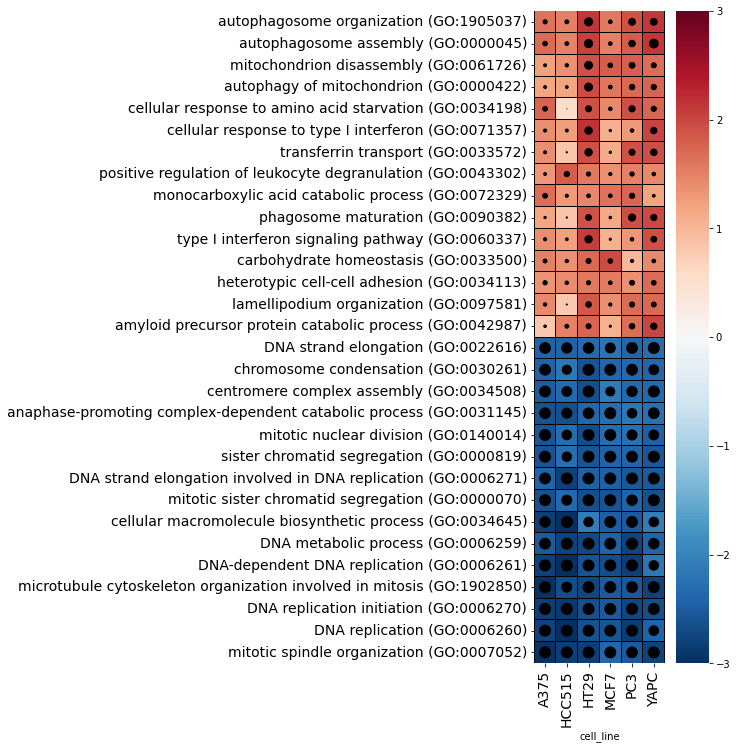

In [214]:
boPlot(corr=pak4i_go_grouped_r2s[case_list].T,
       fdr=pak4i_go_grouped_r2s_fdr[case_list].T,
       fdr_threshold=0,
       vmin=-3.,
       vmax=3.,
       size_adjuster=30,
       path=poseidon_home + 'panels/Figure7/PAK4_go_30_pathway.pdf')

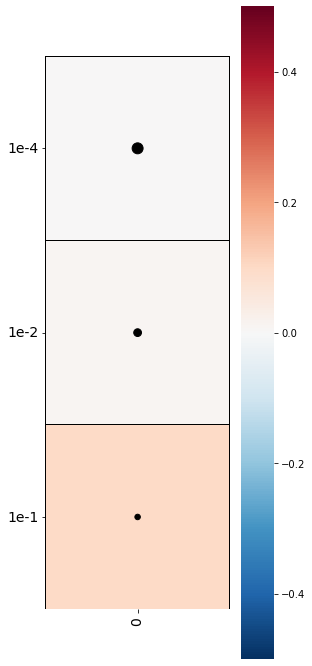

In [213]:
bo_legend = df(index=['1e-4', '1e-2', '1e-1'], columns=['0'])
bo_legend.at['1e-4', '0'] = 1e-4
bo_legend.at['1e-2', '0'] = 1e-2
bo_legend.at['1e-1', '0'] = 1e-1

boPlot(corr=bo_legend.astype(float),
       fdr=-np.log10(bo_legend.astype(float)),
       size_adjuster=30, fdr_threshold=0, vmin=-.5, vmax=.5,
       path=poseidon_home + 'panels/Figure7/PAK4_go_legend.pdf')

In [147]:
pak4i_go_grouped_r2s['cellular response to type I interferon (GO:0071357)']

cell_line
A375      1.386732
HCC515    1.256408
HT29      2.174003
MCF7      1.095431
PC3       1.311502
YAPC      2.027464
Name: cellular response to type I interferon (GO:0071357), dtype: float64

In [148]:
pak4i_go_grouped_r2s['autophagy of mitochondrion (GO:0000422)']

cell_line
A375      1.187334
HCC515    1.217831
HT29      1.966398
MCF7      1.609746
PC3       1.727244
YAPC      1.749047
Name: autophagy of mitochondrion (GO:0000422), dtype: float64

In [51]:
# group by cell line: all
pak4i_go_grouped = pak4i_go_nes.copy().T
pak4i_go_grouped['cell_line'] = sig_pak4['cell_line']
pak4i_go_grouped = pak4i_go_grouped.groupby('cell_line').mean()
pak4i_go_grouped = pak4i_go_grouped.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

In [52]:
pak4i_go_grouped

,DNA metabolic process (GO:0006259),DNA replication (GO:0006260),DNA replication initiation (GO:0006270),DNA strand elongation involved in DNA replication (GO:0006271),DNA-dependent DNA replication (GO:0006261),DNA-dependent DNA replication maintenance of fidelity (GO:0045005),anaphase-promoting complex-dependent catabolic process (GO:0031145),cellular macromolecule biosynthetic process (GO:0034645),chromosome condensation (GO:0030261),double-strand break repair via break-induced replication (GO:0000727),...,negative regulation of insulin receptor signaling pathway (GO:0046627),organophosphate biosynthetic process (GO:0090407),phosphatidylglycerol metabolic process (GO:0046471),positive regulation of developmental growth (GO:0048639),positive regulation of focal adhesion assembly (GO:0051894),positive regulation of receptor-mediated endocytosis (GO:0048260),positive regulation of synapse assembly (GO:0051965),regulation of phosphatase activity (GO:0010921),regulation of protein transport (GO:0051223),regulation of response to cytokine stimulus (GO:0060759)
cell_line,,,,,,,,,,,,,,,,,,,,,
A375,-2.165275,-2.259956,-2.450055,-2.125401,-2.344981,-1.686759,-2.124253,-2.376558,-2.095542,-2.100165,...,1.149017,0.567892,0.537921,0.377306,-0.151421,-0.293728,-0.328188,0.191127,-0.260905,0.585555
A549,-1.875346,-2.130289,-2.169020,-2.208102,-2.185345,-1.944083,-2.072926,-2.537214,-1.746391,-2.221196,...,1.052478,0.721429,0.696303,1.365090,0.328017,-0.680505,-0.288833,0.802144,1.406885,1.262960
HCC515,-2.325778,-2.535563,-2.585208,-2.305018,-2.999993,-1.694669,-2.509170,-2.650228,-1.919911,-2.079698,...,0.907088,0.975014,0.296491,1.161202,-0.243871,0.918795,0.025223,1.145534,0.572019,-0.726376
HELA,-1.289043,-1.273921,-1.628340,-1.540134,-1.640684,-1.049578,-1.827886,-1.963902,-1.831713,-1.664533,...,0.203193,0.928357,-0.637668,0.408761,0.652971,-0.616470,-0.316745,-0.494323,-0.084460,0.129251
HT29,-2.388299,-2.486901,-2.481668,-2.390371,-2.455539,-2.004041,-2.298512,-2.190283,-2.243477,-1.988212,...,0.674837,-0.402099,-0.349431,0.998797,0.412548,0.478621,-0.078288,0.507130,0.667330,0.200634
MCF7,-2.419842,-2.492721,-2.538451,-2.303381,-2.355178,-1.991603,-1.987596,-2.275399,-2.237647,-2.215406,...,0.913047,0.225036,0.835386,0.073280,0.286978,0.463542,0.242122,0.590898,0.962257,0.334089
PC3,-2.753731,-2.870468,-2.756461,-2.507916,-2.900630,-2.249659,-2.330765,-2.521763,-2.328101,-2.342506,...,0.917166,0.570778,0.265698,0.923754,0.424637,0.044987,0.437455,0.610242,1.095319,0.334021
YAPC,-1.913205,-1.342575,-1.945689,-1.746042,-1.157828,-1.680608,-1.491138,-1.724743,-2.099588,-1.896940,...,1.212436,-0.418820,0.084795,0.536722,0.139428,-0.633387,-0.908467,0.053576,-0.067676,0.188799


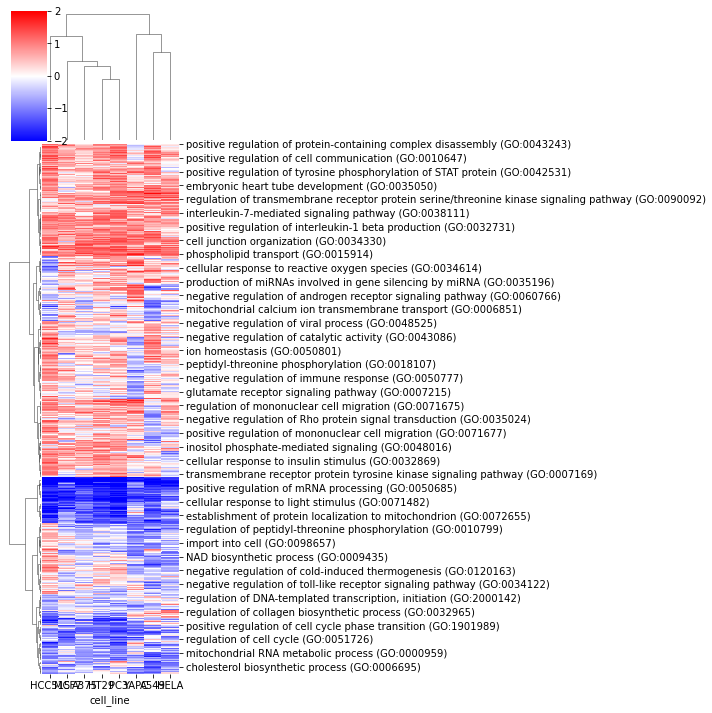

In [56]:
sns.clustermap(pak4i_go_grouped.T,
               method='ward',
               cmap='bwr', vmin=-2., vmax=2.)

In [57]:
pak4i_go_grouped['autophagy of mitochondrion (GO:0000422)']

cell_line
A375      0.539768
A549      0.564308
HCC515    1.008710
HELA     -0.083644
HT29      1.560560
MCF7      1.328219
PC3       1.600808
YAPC      0.637395
Name: autophagy of mitochondrion (GO:0000422), dtype: float64

In [62]:
pak4i_go_grouped['cellular response to type I interferon (GO:0071357)']

cell_line
A375      0.960678
A549      0.311978
HCC515    1.250890
HELA      1.261153
HT29      1.308724
MCF7      0.637485
PC3       0.878116
YAPC      1.768461
Name: cellular response to type I interferon (GO:0071357), dtype: float64

In [64]:
for cl in pak4i_go_grouped.index:
    print(cl)
    print(df(pak4i_go_grouped.T[cl]).sort_values(by=cl, ascending=False)[:20])
    print(df(pak4i_go_grouped.T[cl]).sort_values(by=cl, ascending=True)[:20])

A375
                                                        A375
cellular response to amino acid starvation (GO:...  1.827063
regulation of TORC1 signaling (GO:1903432)          1.725037
response to amino acid starvation (GO:1990928)      1.724314
autophagosome assembly (GO:0000045)                 1.692020
autophagosome organization (GO:1905037)             1.686922
cellular response to starvation (GO:0009267)        1.604543
cellular response to amino acid stimulus (GO:00...  1.559026
positive regulation of macroautophagy (GO:0016239)  1.558988
response to UV-B (GO:0010224)                       1.557310
positive regulation of small GTPase mediated si...  1.538710
regulation of stress-activated protein kinase s...  1.528105
negative regulation of programmed necrotic cell...  1.506650
positive regulation of reactive oxygen species ...  1.499033
regulation of macrophage differentiation (GO:00...  1.481853
regulation of necroptotic process (GO:0060544)      1.459240
monocarboxylic acid

In [71]:
# merged
df(pak4i_go_nes.mean(axis=1)).sort_values(by=0, ascending=False)[:50]

,0
regulation of cell population proliferation (GO:0042127),inf
regulation of intracellular signal transduction (GO:1902531),inf
regulation of apoptotic process (GO:0042981),inf
protein ubiquitination (GO:0016567),inf
cellular protein modification process (GO:0006464),inf
autophagosome organization (GO:1905037),1.588074
autophagosome assembly (GO:0000045),1.550170
cellular response to amino acid starvation (GO:0034198),1.437626
cellular response to starvation (GO:0009267),1.381659
response to amino acid starvation (GO:1990928),1.362759


In [84]:
# corr shift ability
pak4_shift_go = df(index=pak4i_go_grouped.index, columns=pak4i_go_grouped.columns)
for c in sig_pak4['cell_line'].unique():
    tmp_sig = sig_pak4[sig_pak4['cell_line'] == c]
    tmp_nes = pak4i_go_nes[tmp_sig.index].T

    pak4_shift_go.at[c, :] = tmp_nes.corrwith(tmp_sig['shift_ability'], axis=0)

        

In [88]:
pak4_shift_go['autophagy of mitochondrion (GO:0000422)']

cell_line
A375       0.566747
A549       0.529012
HCC515    -0.370525
HELA       0.342725
HT29       0.534922
MCF7      0.0198609
PC3        0.369269
YAPC       0.335072
Name: autophagy of mitochondrion (GO:0000422), dtype: object

In [90]:
pak4_shift_go['cellular response to type I interferon (GO:0071357)']

cell_line
A375       0.464505
A549       0.677632
HCC515     0.105242
HELA      -0.795006
HT29       0.830323
MCF7      0.0225719
PC3        0.201159
YAPC       0.447171
Name: cellular response to type I interferon (GO:0071357), dtype: object

LJP009_A375_24H:D02      0.685602
MOAR004_A375_24H:A17     1.182530
MOAR004_A375_24H:A18     0.998210
REP.A014_A375_24H:K13    1.882995
MOAR004_A375_24H:A16     1.636180
REP.A014_A375_24H:K14    1.126465
REP.B014_A375_24H:K13    1.444641
REP.B014_A375_24H:K14   -1.157583
REP.A014_A375_24H:K16    1.249205
REP.B014_A375_24H:K15   -0.682385
LJP009_A375_24H:D03     -1.142997
REP.A014_A375_24H:K17   -1.150471
REP.A014_A375_24H:K15    0.944591
Name: autophagy of mitochondrion (GO:0000422), dtype: float64


<AxesSubplot:xlabel='shift_ability', ylabel='autophagy of mitochondrion (GO:0000422)'>

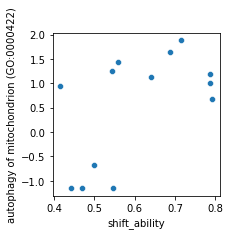

In [142]:
plt.figure(figsize=(3, 3))
tmp_sig = sig_pak4[sig_pak4['cell_line'] == 'A375']
tmp_nes = pak4i_go_nes[tmp_sig.index].T
print(tmp_nes['autophagy of mitochondrion (GO:0000422)'])
sns.scatterplot(x=tmp_sig['shift_ability'], y=tmp_nes['autophagy of mitochondrion (GO:0000422)'])

<AxesSubplot:xlabel='shift_ability', ylabel='cellular response to type I interferon (GO:0071357)'>

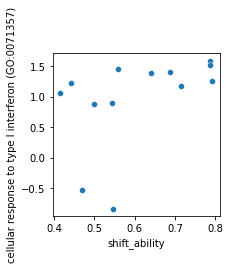

In [102]:
plt.figure(figsize=(3, 3))
tmp_sig = sig_pak4[sig_pak4['cell_line'] == 'A375']
tmp_nes = pak4i_go_nes[tmp_sig.index].T
sns.scatterplot(x=tmp_sig['shift_ability'], y=tmp_nes['cellular response to type I interferon (GO:0071357)'])

<AxesSubplot:xlabel='shift_ability', ylabel='autophagy of mitochondrion (GO:0000422)'>

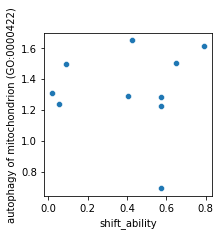

In [94]:
plt.figure(figsize=(3, 3))
tmp_sig = sig_pak4[sig_pak4['cell_line'] == 'MCF7']
tmp_nes = pak4i_go_nes[tmp_sig.index].T
sns.scatterplot(x=tmp_sig['shift_ability'], y=tmp_nes['autophagy of mitochondrion (GO:0000422)'])

<AxesSubplot:xlabel='shift_ability', ylabel='autophagy of mitochondrion (GO:0000422)'>

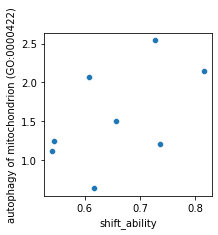

In [96]:
plt.figure(figsize=(3, 3))
tmp_sig = sig_pak4[sig_pak4['cell_line'] == 'HT29']
tmp_nes = pak4i_go_nes[tmp_sig.index].T
sns.scatterplot(x=tmp_sig['shift_ability'], y=tmp_nes['autophagy of mitochondrion (GO:0000422)'])

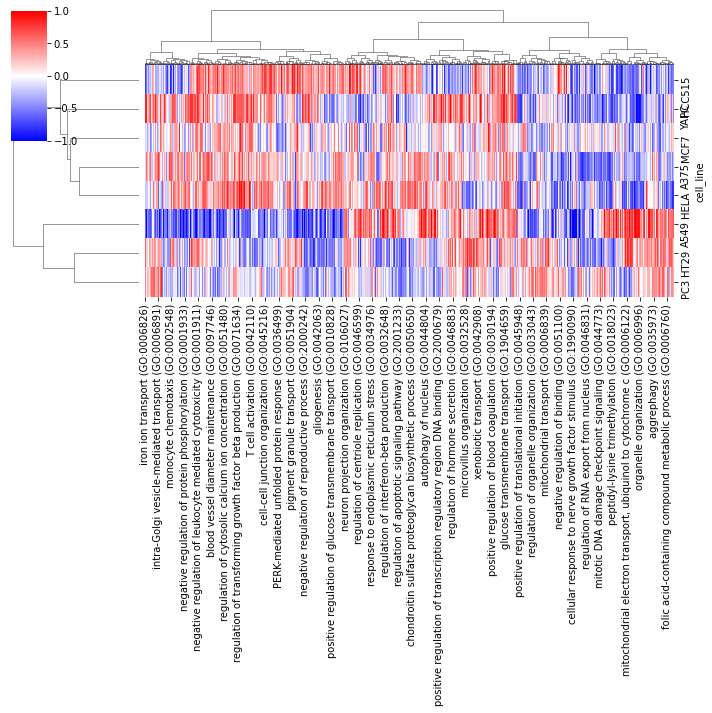

In [101]:
sns.clustermap(pak4_shift_go.astype(float),
               method='ward',
               cmap='bwr', vmin=-1., vmax=1.)

In [126]:
for cl in pak4i_go_grouped.index:
    print(cl)
    print(df(pak4_shift_go.T[cl]).sort_values(by=cl, ascending=False)[:20])
    print(df(pak4_shift_go.T[cl]).sort_values(by=cl, ascending=True)[:20])

A375
                                                        A375
cellular defense response (GO:0006968)              0.828919
GPI anchor metabolic process (GO:0006505)           0.824005
preassembly of GPI anchor in ER membrane (GO:00...  0.818453
regulation of NIK/NF-kappaB signaling (GO:1901222)  0.815868
fatty acid transmembrane transport (GO:1902001)     0.809305
microglial cell activation (GO:0001774)             0.803368
cellular response to chemical stress (GO:0062197)    0.80172
modulation of excitatory postsynaptic potential...  0.787747
phosphatidylethanolamine metabolic process (GO:...  0.782253
calcium-mediated signaling (GO:0019722)             0.772474
regulation of leukocyte cell-cell adhesion (GO:...    0.7689
calcium ion homeostasis (GO:0055074)                0.763993
sensory perception (GO:0007600)                     0.762545
negative regulation of cell-substrate junction ...  0.757589
negative regulation of focal adhesion assembly ...  0.757473
positive regulation

# MoS (2.0)

In [52]:
r2s_all = merged_compound[merged_compound['shift_ability'] >= .7]
print(r2s_all.shape)

(3983, 7)


In [53]:
ec_bing_matrix_hi = pd.read_csv(data_home + 'lv5_shift_S_0.7_matrix.csv',
                                header=0, index_col=0, sep=',')

In [54]:
# calculate consensus gene alteration by each drug
con_bing_matrix = ec_bing_matrix_hi.copy().T
con_bing_matrix['cmap_name'] = r2s_all['cmap_name']
con_bing_matrix = con_bing_matrix.groupby('cmap_name').mean().T

In [55]:
con_bing_matrix

cmap_name,3-Cl-AHPC,5-BDBD,5-iodotubercidin,7b-cis,A-443654,ABT-737,ABT-751,ACY-1215,AG-592,AMG-232,...,vemurafenib,venlafaxine,volasertib,voreloxin,voriconazole,vorinostat,voxtalisib,withaferin-a,wortmannin,zileuton
KLHL21,0.877389,4.386404,-1.127771,0.196837,-1.819617,0.839649,-0.079560,-0.884355,-0.090596,2.478765,...,-2.050607,-1.384016,0.643557,4.388901,-0.253715,0.296302,-0.376074,4.745129,1.352517,3.438691
MMP1,0.828896,2.194270,2.855546,1.364217,1.142815,0.671538,1.889079,0.839632,3.565955,0.245626,...,-1.341491,1.848995,2.007126,0.170926,3.309143,3.620154,0.758310,3.909508,1.405352,0.628637
RGS2,2.625413,2.412134,-3.039554,-2.804540,-4.788108,-1.362392,3.871835,1.396049,-2.418592,2.660261,...,-2.672538,-5.046933,2.103863,3.306682,0.170181,3.135213,0.621248,5.547899,-0.170797,-1.502308
INSIG1,-1.190773,-0.048188,-0.295479,0.960580,-0.632611,1.146418,0.401020,0.057255,-0.370663,-1.516677,...,0.855051,3.069688,2.701495,-3.442315,0.861240,4.710800,-1.170882,2.180090,0.011520,1.296864
HSPA1A,0.018839,1.917393,0.504898,-1.063505,-6.788588,-0.976098,0.555336,-0.070194,-4.483434,-1.401443,...,-2.106529,0.723244,-2.302930,-1.759475,-4.184002,2.883328,1.021556,5.713271,-0.740808,1.701406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACAT2,-1.333088,-3.904829,2.137462,0.818804,-0.705020,0.254434,-0.117142,-4.656200,-3.178690,-2.257223,...,-1.691297,-9.853667,-0.257740,-0.538663,-0.277463,-1.574538,-5.209637,-0.144519,-1.015041,-0.101880
ELAC2,-0.089028,-0.072138,0.389690,-0.937046,-3.491441,-0.029664,0.580767,-1.164870,-4.443474,-1.116215,...,-1.172650,0.566863,-0.870558,-0.093377,-0.099366,-1.663444,-2.164714,-3.541215,-1.277234,-3.151525
C2CD5,-3.885487,-1.452381,-7.916183,-2.747507,-2.174159,-0.629925,-1.561589,-5.285458,-0.007685,-1.986692,...,3.024298,-4.929600,-2.918865,-2.568161,-0.556538,-4.857127,1.333191,-6.078823,0.505972,-0.649819
PLK1,-7.598260,-2.493941,-4.959005,-4.414743,-3.294340,-3.303470,-3.264866,-4.542681,-3.095117,-6.351573,...,-4.715659,0.540966,-0.621071,-9.182735,-6.459907,-5.131101,-7.016683,-4.990838,-5.365734,-3.673478


In [276]:
con_corr = con_bing_matrix.corr()

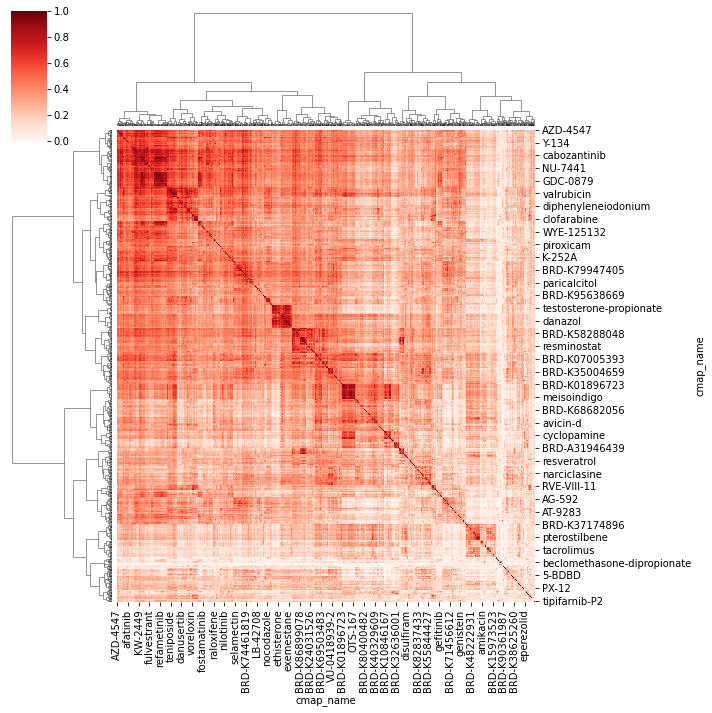

In [279]:
sns.clustermap(con_corr, cmap='Reds', method='ward', vmin=0, vmax=1)

In [307]:
rnk = df(con_bing_matrix['PF-03758309']).sort_values(by='PF-03758309', ascending=False)['PF-03758309']
pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + 'gene_sets/WolfEtAl_71_Symbols.gmt',
                     processes=20,
                     permutation_num=100,
                     outdir=None, seed=0, min_size=10, max_size=2000)
tmp_im_result = pre_res.res2d

In [309]:
tmp_im_result.sort_values(by='nes', ascending=False)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Module3_IFN_score,0.657181,2.154262,0.000000,0.000000,24,24,HERC6;IFI27;TAP1;DDX58;SAMD9;IFIH1;OASL;IFI6;I...,HERC6;IFI27;TAP1;DDX58;SAMD9;IFIH1;OASL;IFI6;I...
HER2_Immune_PCA_18006808,0.326578,1.718430,0.000000,0.048527,866,733,P4HA2;FHL2;COL4A1;PRKCQ;NUDT9;CDIPT;ICAM3;STK1...,P4HA2;FHL2;COL4A1;PRKCQ;NUDT9;CDIPT;ICAM3;STK1...
IFN_21978456,0.639617,1.687147,0.000000,0.048527,13,13,HERC6;IFI27;OASL;ISG15;RSAD2;OAS1;MX1;OAS2;OAS...,HERC6;IFI27;OASL;ISG15;RSAD2;OAS1;MX1;OAS2
Interferon_19272155,0.632225,1.682435,0.000000,0.036395,13,13,IFI27;IFI6;ISG15;RSAD2;DDX60;OAS1;MX1;OAS2;OAS...,IFI27;IFI6;ISG15;RSAD2;DDX60;OAS1;MX1;OAS2
Interferon_Cluster_21214954,0.493003,1.665545,0.000000,0.035586,36,36,HERC6;IFI27;PARP12;SP110;IRF7;C19orf66;DDX58;S...,HERC6;IFI27;PARP12;SP110;IRF7;C19orf66;DDX58;S...
STAT1_score,0.403935,1.608731,0.000000,0.048527,89,77,HERC6;TAP1;GLRX;EFNA1;DDX58;RFX5;CCL5;IFI6;ISG...,HERC6;TAP1;GLRX;EFNA1;DDX58;RFX5;CCL5;IFI6;ISG...
GRANS_PCA_16704732,0.317248,1.540581,0.000000,0.092432,347,268,DHRS7;HSPA1A;CDIPT;ICAM3;TM9SF2;ST6GALNAC2;FAM...,DHRS7;HSPA1A;CDIPT;ICAM3;TM9SF2;ST6GALNAC2;FAM...
Minterferon_Cluster_21214954,0.418766,1.507890,0.000000,0.105142,48,36,PARP12;SP100;DDX58;IFIH1;OASL;CCL5;ISG15;RSAD2...,PARP12;SP100;DDX58;IFIH1;OASL;CCL5;ISG15;RSAD2...
ZHANG_INTERFERON_RESPONSE,0.523653,1.507834,0.023810,0.093459,23,21,IFI27;SP110;OASL;ISG20;ISG15;STAT1;IRF9;IFITM1...,IFI27;SP110;OASL;ISG20;ISG15;STAT1;IRF9;IFITM1...


In [250]:
rnk = df(con_bing_matrix['PF-03758309']).sort_values(by='PF-03758309', ascending=False)['PF-03758309']
pre_res = gp.prerank(rnk=rnk, gene_sets='GO_Biological_Process_2021',
                     processes=20,
                     permutation_num=100,
                     outdir=None, seed=0, min_size=10, max_size=2000)
tmp_result = pre_res.res2d

In [252]:
tmp_result.sort_values(by='nes', ascending=False)[:10]

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
transferrin transport (GO:0033572),0.654785,2.219613,0.000000,0.000000,36,27,ATP6V1D;MCOLN1;ATP6V0D1;CLTC;ARHGAP1;DNM2;ATP6...,ATP6V1D;MCOLN1;ATP6V0D1;CLTC;ARHGAP1;DNM2;ATP6...
autophagosome organization (GO:1905037),0.621396,2.196254,0.000000,0.000000,56,36,PIK3C3;MAP1LC3B;GABARAPL2;STX12;UBQLN2;ATG9A;W...,PIK3C3;MAP1LC3B;GABARAPL2;STX12;UBQLN2;ATG9A;W...
regulation of axon extension (GO:0030516),0.647722,2.166418,0.000000,0.008930,38,27,CTTN;MACF1;CDKL3;DNM2;MAP3K13;MT3;ABL1;MAP2;SE...,CTTN;MACF1;CDKL3;DNM2;MAP3K13;MT3;ABL1;MAP2;SE...
cellular response to amino acid starvation (GO:0034198),0.566244,2.087764,0.000000,0.026791,74,52,CDKN1A;ATP6V1D;SESN1;ATP6V0D1;RRAGA;SH3GLB1;AT...,CDKN1A;ATP6V1D;SESN1;ATP6V0D1;RRAGA;SH3GLB1;AT...
phosphatidylethanolamine metabolic process (GO:0046337),0.783233,2.074117,0.000000,0.032150,31,16,ABHD4;PLA2G15;ETNK1;PLA2G6;LPIN1;CEPT1;CHKB;PL...,ABHD4;PLA2G15;ETNK1;PLA2G6;LPIN1;CEPT1;CHKB;PL...
extrinsic apoptotic signaling pathway via death domain receptors (GO:0008625),0.652112,2.056618,0.000000,0.033489,30,21,TNFRSF10B;TRADD;TNFRSF10C;SORT1;MOAP1;BID;FADD...,TNFRSF10B;TRADD;TNFRSF10C;SORT1;MOAP1;BID;FADD...
cellular response to starvation (GO:0009267),0.470725,2.047763,0.000000,0.030619,158,110,CDKN1A;ATP6V1D;PIK3C3;SESN1;MAP1LC3B;ATP6V0D1;...,CDKN1A;ATP6V1D;PIK3C3;SESN1;MAP1LC3B;ATP6V0D1;...
response to amino acid starvation (GO:1990928),0.551186,2.017215,0.000000,0.041862,75,53,CDKN1A;ATP6V1D;SESN1;ATP6V0D1;RRAGA;SH3GLB1;AT...,CDKN1A;ATP6V1D;SESN1;ATP6V0D1;RRAGA;SH3GLB1;AT...
amyloid precursor protein catabolic process (GO:0042987),0.759112,1.998975,0.019608,0.041675,14,13,PSEN1;APH1B;ABCA7;ADAM10;ABCG1;ADAM17;ADAM19;B...,PSEN1;APH1B;ABCA7;ADAM10;ABCG1;ADAM17;ADAM19;B...


In [56]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy

In [166]:
dich_bing_matrix

cmap_name,3-Cl-AHPC,5-BDBD,5-iodotubercidin,7b-cis,A-443654,ABT-737,ABT-751,ACY-1215,AG-592,AMG-232,...,vemurafenib,venlafaxine,volasertib,voreloxin,voriconazole,vorinostat,voxtalisib,withaferin-a,wortmannin,zileuton
KLHL21,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,...,-1.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
MMP1,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
RGS2,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.0
INSIG1,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,...,0.0,1.0,1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,1.0
HSPA1A,0.0,1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,...,-1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACAT2,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0
ELAC2,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
C2CD5,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,...,1.0,-1.0,-1.0,-1.0,0.0,-1.0,1.0,-1.0,0.0,0.0
PLK1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [57]:
dich_bing_matrix = con_bing_matrix.copy()
dich_bing_matrix = dich_bing_matrix[dich_bing_matrix < 1].fillna(1)
dich_bing_matrix = dich_bing_matrix[dich_bing_matrix > -1].fillna(-1)
dich_bing_matrix = dich_bing_matrix[abs(dich_bing_matrix) == 1].fillna(0)

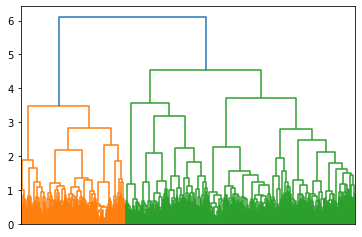

In [58]:
distanceMatrix = pdist(dich_bing_matrix.T, metric='cosine')
dend_dich = dendrogram(linkage(distanceMatrix, method='ward'), 
                  color_threshold=5,
                  no_labels=True,
                  leaf_font_size=1)

In [59]:
cluster_dich_size = {}
for c in set(dend_dich['color_list']):
    print(c)
    print(len([i for i in dend_dich['color_list'] if i == c]) + 1)
    cluster_dich_size[c] = len([i for i in dend_dich['color_list'] if i == c]) + 1

C1
244
C0
2
C2
536


In [60]:
# assign super cluster
cluster_dich = df(index=con_bing_matrix.columns, columns=['cluster'])
tmp_ind = 0
for i in range(2):
    tmp_c = i + 1
    tmp_c_name = 'C' + str(tmp_c)

    for j in range(cluster_dich_size[tmp_c_name]):
        cluster_dich.at[cluster_dich.index[dend_dich['leaves'][tmp_ind + j]], 'cluster'] = 'super_' + tmp_c_name
    tmp_ind = tmp_ind + cluster_dich_size[tmp_c_name]

In [61]:
cluster_dich['moa'] = compound_info['moa']

In [62]:
cluster_dich[cluster_dich['moa'] == 'MEK inhibitor']

,cluster,moa
cmap_name,,
AS-703026,super_C2,MEK inhibitor
PD-0325901,super_C2,MEK inhibitor
PD-184352,super_C2,MEK inhibitor
PD-198306,super_C2,MEK inhibitor
PD-98059,super_C2,MEK inhibitor
Ro-4987655,super_C2,MEK inhibitor
TAK-733,super_C2,MEK inhibitor
U-0126,super_C1,MEK inhibitor
refametinib,super_C2,MEK inhibitor


In [63]:
cluster_dich[cluster_dich['moa'] == 'HDAC inhibitor']

,cluster,moa
cmap_name,,
ACY-1215,super_C2,HDAC inhibitor
HDAC3-selective,super_C2,HDAC inhibitor
ISOX,super_C2,HDAC inhibitor
JNJ-26481585,super_C2,HDAC inhibitor
Merck60,super_C2,HDAC inhibitor
NCH-51,super_C2,HDAC inhibitor
PCI-24781,super_C2,HDAC inhibitor
SB-939,super_C2,HDAC inhibitor
WT-171,super_C2,HDAC inhibitor


In [64]:
pd.crosstab(cluster_dich['cluster'], cluster_dich['moa']).T.sort_values(by='super_C2', ascending=False)[:20]

cluster,super_C1,super_C2
moa,,
HDAC inhibitor,2,19
Topoisomerase inhibitor,1,16
MTOR inhibitor,2,12
EGFR inhibitor,4,11
MEK inhibitor,1,10
RAF inhibitor,0,7
HMGCR inhibitor,0,7
KIT inhibitor,1,6
PI3K inhibitor,2,6


In [65]:
cluster_dich.loc['doxorubicin', :]

cluster                   super_C2
moa        Topoisomerase inhibitor
Name: doxorubicin, dtype: object

In [431]:
cluster_dich.loc['gemcitabine', :]

cluster                              super_C2
moa        Ribonucleotide reductase inhibitor
Name: gemcitabine, dtype: object

In [432]:
cluster_dich.loc['palbociclib', :]

cluster         super_C2
moa        CDK inhibitor
Name: palbociclib, dtype: object

In [405]:
cluster_dich[cluster_dich['moa'] == 'P21 activated kinase inhibitor']

,cluster,moa
cmap_name,,
PF-03758309,super_C2,P21 activated kinase inhibitor


In [66]:
# take cluster average
dich_bing_cluster = dich_bing_matrix.copy().T
dich_bing_cluster['cluster'] = cluster_dich['cluster']
dich_bing_cluster = dich_bing_cluster.groupby('cluster').mean().T
dich_bing_cluster

cluster,super_C1,super_C2
KLHL21,0.139344,0.240672
MMP1,0.676230,0.369403
RGS2,-0.012295,0.106343
INSIG1,0.221311,0.311567
HSPA1A,-0.192623,-0.106343
...,...,...
ACAT2,0.012295,-0.203358
ELAC2,-0.422131,-0.572761
C2CD5,-0.577869,-0.324627
PLK1,-0.721311,-0.865672


In [84]:
cluster_dich_gsea = {}
for c in dich_bing_cluster.columns:
    rnk = dich_bing_cluster.sort_values(by=c, ascending=False)[c]
    pre_res = gp.prerank(rnk=rnk, gene_sets='GO_Biological_Process_2021',
                         processes=20,
                         permutation_num=1000,
                         outdir=None, seed=0, min_size=10, max_size=2000)
    tmp_result = pre_res.res2d
    cluster_dich_gsea[c] = tmp_result


<ipython-input-84-c2735fdae02b>:4: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(rnk=rnk, gene_sets='GO_Biological_Process_2021',
2023-06-06 17:21:53,454 [WARNING] Duplicated values found in preranked stats: 96.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-06-06 17:22:20,774 [WARNING] Duplicated values found in preranked stats: 92.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [85]:
cluster_dich_gsea['super_C1']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,ribosome biogenesis (GO:0042254),-0.725845,-4.51149,0,0,0,109/146,18.77%,NOP56;XPO1;DKC1;ABCE1;NOP16;RAN;WDR12;RRP1B;WD...
1,prerank,rRNA processing (GO:0006364),-0.724183,-4.48191,0,0,0,101/137,18.77%,NOP56;DKC1;WDR12;RRP1B;WDR43;EXOSC8;EXOSC9;MAK...
2,prerank,rRNA metabolic process (GO:0016072),-0.728589,-4.34026,0,0,0,91/122,18.77%,NOP56;DKC1;WDR12;RRP1B;WDR43;EXOSC8;EXOSC9;UTP...
3,prerank,ncRNA processing (GO:0034470),-0.678441,-4.2714,0,0,0,108/155,19.45%,NOP56;DKC1;WDR12;RRP1B;WDR43;EXOSC8;RPP30;HNRN...
4,prerank,ribonucleoprotein complex assembly (GO:0022618),-0.710485,-4.24508,0,0,0,72/110,15.99%,MRPS7;SNRPD1;PRMT5;SNRPF;HSP90AA1;CPSF6;XRCC5;...
...,...,...,...,...,...,...,...,...,...,...
3082,prerank,endoplasmic reticulum calcium ion homeostasis ...,0.136427,0.407447,1,1,1,7/17,46.91%,KCTD17;PML;PACS2;BAK1;WFS1;BAX;BCL2
3083,prerank,protein targeting to membrane (GO:0006612),0.102963,0.392406,1,1,1,24/56,50.27%,ABCD1;ABCD2;RTP4;CHM;SIL1;NACAD;TAOK2;GDAP1;PR...
3084,prerank,anion transmembrane transport (GO:0098656),0.107652,0.38621,1,1,1,13/42,40.36%,SLC6A9;SLC13A3;SLC6A13;SLC1A6;SLC7A8;SLC1A2;SL...
3085,prerank,protein localization to lysosome (GO:0061462),0.114189,0.365758,0.998767,1,1,10/24,48.89%,SZT2;LMBRD1;LAPTM5;SCARB2;SNX16;NAGPA;AP4M1;RN...


In [86]:
cluster_dich_go_nes = pd.concat([df(cluster_dich_gsea[k].set_index('Term')['NES']).rename(columns={'NES': k}) for k in cluster_dich_gsea.keys()], axis=1)
cluster_dich_go_fdr = pd.concat([df(cluster_dich_gsea[k].set_index('Term')['FDR q-val']).rename(columns={'FDR q-val': k}) for k in cluster_dich_gsea.keys()], axis=1)

In [87]:
cluster_dich_go_nes

,super_C1,super_C2
ribosome biogenesis (GO:0042254),-4.51149,-3.45255
rRNA processing (GO:0006364),-4.48191,-3.38042
rRNA metabolic process (GO:0016072),-4.34026,-3.37464
ncRNA processing (GO:0034470),-4.2714,-3.33124
ribonucleoprotein complex assembly (GO:0022618),-4.24508,-3.03546
...,...,...
endoplasmic reticulum calcium ion homeostasis (GO:0032469),0.407447,1.43922
protein targeting to membrane (GO:0006612),0.392406,0.879971
anion transmembrane transport (GO:0098656),0.38621,-0.775711
protein localization to lysosome (GO:0061462),0.365758,1.13371


In [88]:
cluster_dich_go_nes = cluster_dich_go_nes.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any')

cluster_dich_go_fdr = cluster_dich_go_fdr.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any')

In [89]:
cluster_dich_go_logfdr = -np.log10(cluster_dich_go_fdr + 0.0001) * np.sign(cluster_dich_go_nes)

In [90]:
cluster_dich_go_logfdr

,super_C1,super_C2
ribosome biogenesis (GO:0042254),-4.000000,-4.000000
rRNA processing (GO:0006364),-4.000000,-4.000000
rRNA metabolic process (GO:0016072),-4.000000,-4.000000
ncRNA processing (GO:0034470),-4.000000,-4.000000
ribonucleoprotein complex assembly (GO:0022618),-4.000000,-4.000000
...,...,...
endoplasmic reticulum calcium ion homeostasis (GO:0032469),-0.000043,0.765619
protein targeting to membrane (GO:0006612),-0.000043,0.125684
anion transmembrane transport (GO:0098656),-0.000043,-0.050666
protein localization to lysosome (GO:0061462),-0.000043,0.383166


In [91]:
cluster_dich_go_nes.loc['cellular response to type I interferon (GO:0071357)']

super_C1    1.403558
super_C2    2.332768
Name: cellular response to type I interferon (GO:0071357), dtype: float64

In [92]:
cluster_dich_go_logfdr.sort_values(by='super_C1', ascending=False)[:25]

,super_C1,super_C2
positive regulation of cytosolic calcium ion concentration (GO:0007204),4.000000,1.323785
action potential (GO:0001508),3.500661,1.010702
potassium ion transport (GO:0006813),3.411546,1.135309
membrane depolarization during action potential (GO:0086010),3.351450,0.905981
positive regulation of phagocytosis (GO:0050766),3.274502,1.347675
enzyme linked receptor protein signaling pathway (GO:0007167),3.170487,1.425670
neuronal action potential (GO:0019228),2.928584,1.117560
potassium ion transmembrane transport (GO:0071805),2.875222,1.130697
positive regulation of cation transmembrane transport (GO:1904064),2.855587,0.752081
positive regulation of potassium ion transmembrane transport (GO:1901381),2.843539,0.903317


In [93]:
cluster_dich_go_logfdr.sort_values(by='super_C2', ascending=False)[:25]

,super_C1,super_C2
interferon-gamma-mediated signaling pathway (GO:0060333),1.310687,3.236709
type I interferon signaling pathway (GO:0060337),0.681259,3.086331
mitochondrion disassembly (GO:0061726),0.073142,3.086331
cellular response to type I interferon (GO:0071357),0.681259,3.086331
autophagy of mitochondrion (GO:0000422),0.023457,2.738180
negative regulation of lipid storage (GO:0010888),0.406330,2.404665
cellular response to interferon-gamma (GO:0071346),1.093552,2.136840
positive regulation of autophagy (GO:0010508),0.126294,1.940979
carbohydrate homeostasis (GO:0033500),0.666250,1.908849
amyloid fibril formation (GO:1990000),0.105401,1.884221


(-0.1, 4.1)

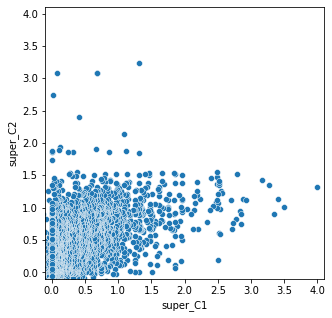

In [95]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='super_C1', y='super_C2', data=cluster_dich_go_logfdr)
plt.xlim(-.1, 4.1)
plt.ylim(-.1, 4.1)

In [97]:
cluster_dich_im_gsea = {}
for c in dich_bing_cluster.columns:
    rnk = dich_bing_cluster.sort_values(by=c, ascending=False)[c]
    pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + 'gene_sets/WolfEtAl_71_Symbols.gmt',
                         processes=20,
                         permutation_num=100,
                         outdir=None, seed=0, min_size=10, max_size=2000)
    tmp_result = pre_res.res2d
    cluster_dich_im_gsea[c] = tmp_result

<ipython-input-97-7a76be0a04ac>:4: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + 'gene_sets/WolfEtAl_71_Symbols.gmt',
2023-06-06 17:25:18,179 [WARNING] Duplicated values found in preranked stats: 96.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-06-06 17:25:18,522 [WARNING] Duplicated values found in preranked stats: 92.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [100]:
cluster_dich_im_go_nes = pd.concat([df(cluster_dich_im_gsea[k].set_index('Term')['NES']).rename(columns={'NES': k}) for k in cluster_dich_im_gsea.keys()], axis=1)
cluster_dich_im_go_fdr = pd.concat([df(cluster_dich_im_gsea[k].set_index('Term')['FDR q-val']).rename(columns={'FDR q-val': k}) for k in cluster_dich_im_gsea.keys()], axis=1)

In [101]:
cluster_dich_im_go_nes = cluster_dich_im_go_nes.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any')

In [102]:
cluster_dich_im_go_nes['class'] = immunity_class['class']
cluster_dich_im_go_nes = cluster_dich_im_go_nes.groupby('class').mean()

NameError: name 'immunity_class' is not defined

In [417]:
cluster_dich_im_go_nes

,super_C1,super_C2
class,,
Antigen Presentation,1.510736,1.431719
B cell,1.637590,1.548781
Cytokine,1.499375,1.188066
Cytotoxic T cell,1.730557,1.407027
DC cells,1.626385,1.554396
IFN Signaling,1.413077,1.863353
Leukocyte,1.552849,1.314699
Other,1.587836,1.556276
Proliferation,-4.184783,-3.573657


In [103]:
distanceMatrix = pdist(con_bing_matrix.T, metric='correlation')

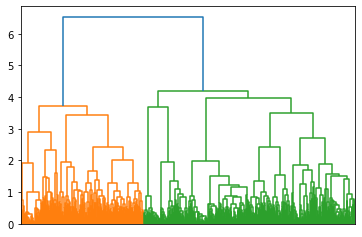

In [104]:
dend_super = dendrogram(linkage(distanceMatrix, method='ward'), 
                  color_threshold=5,
                  no_labels=True,
                  leaf_font_size=1)

fig = plt.gcf()
fig.savefig(panel_home + 'clustering_780.pdf', transparent=True)
fig.savefig(panel_home + 'clustering_780.png', dpi=300, transparent=True)

In [105]:
cluster_super_size = {}
for c in set(dend_super['color_list']):
    print(c)
    print(len([i for i in dend_super['color_list'] if i == c]) + 1)
    cluster_super_size[c] = len([i for i in dend_super['color_list'] if i == c]) + 1

C1
288
C0
2
C2
492


In [106]:
# assign super cluster
cluster_super = df(index=con_bing_matrix.columns, columns=['cluster'])
tmp_ind = 0
for i in range(2):
    tmp_c = i + 1
    tmp_c_name = 'C' + str(tmp_c)

    for j in range(cluster_super_size[tmp_c_name]):
        cluster_super.at[cluster_super.index[dend_super['leaves'][tmp_ind + j]], 'cluster'] = 'super_' + tmp_c_name
    tmp_ind = tmp_ind + cluster_super_size[tmp_c_name]

In [107]:
cluster_super['moa'] = compound_info['moa']

In [108]:
cluster_super.loc['trametinib', :]

cluster         super_C2
moa        MEK inhibitor
Name: trametinib, dtype: object

In [109]:
cluster_super.loc['PF-03758309', :]

cluster                          super_C2
moa        P21 activated kinase inhibitor
Name: PF-03758309, dtype: object

In [110]:
cluster_super.loc['vorinostat', :]

cluster          super_C2
moa        HDAC inhibitor
Name: vorinostat, dtype: object

In [111]:
cluster_super.loc['gemcitabine', :]

cluster                              super_C2
moa        Ribonucleotide reductase inhibitor
Name: gemcitabine, dtype: object

In [257]:
# take cluster average
con_bing_cluster = con_bing_matrix.copy().T
con_bing_cluster['cluster'] = cluster_super['cluster']
con_bing_cluster = con_bing_cluster.groupby('cluster').median().T
con_bing_cluster

cluster,super_C1,super_C2
KLHL21,0.466527,0.459125
MMP1,1.866153,0.681401
RGS2,0.571431,0.064586
INSIG1,0.771364,0.981093
HSPA1A,-0.173991,-0.481139
...,...,...
ACAT2,-0.078237,-0.627609
ELAC2,-1.082805,-1.117139
C2CD5,-2.077019,-0.849198
PLK1,-2.761860,-3.812679


In [308]:
cluster_gsea = {}
result_gsea = {}
for c in con_bing_cluster.columns:
    rnk = con_bing_cluster.sort_values(by=c, ascending=False)[c]
    pre_res = gp.prerank(rnk=rnk, gene_sets='GO_Biological_Process_2021',
                         threads=20,
                         permutation_num=1000,
                         outdir=None, seed=0, min_size=10, max_size=2000)
    tmp_result = pre_res.res2d
    cluster_gsea[c] = tmp_result
    result_gsea[c] = pre_res


2023-06-06 18:02:43,143 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-06-06 18:03:10,816 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [294]:
cluster_go_nes = pd.concat([df(cluster_gsea[k].set_index('Term')['NES']).rename(columns={'NES': k}) for k in cluster_gsea.keys()], axis=1)
cluster_go_fdr = pd.concat([df(cluster_gsea[k].set_index('Term')['FDR q-val']).rename(columns={'FDR q-val': k}) for k in cluster_gsea.keys()], axis=1)

<AxesSubplot:xlabel='super_C1', ylabel='super_C2'>

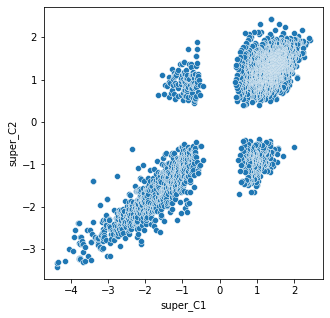

In [295]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='super_C1', y='super_C2', data=cluster_go_nes)

In [296]:
cluster_go_nes['difference'] = cluster_go_nes['super_C1'] - cluster_go_nes['super_C2']
cluster_go_nes = cluster_go_nes.sort_values(by='difference', ascending=True)

In [297]:
cluster_go_nes.loc['cellular response to type I interferon (GO:0071357)']

super_C1       1.3958
super_C2      2.42173
difference   -1.02593
Name: cellular response to type I interferon (GO:0071357), dtype: object

In [298]:
cluster_go_nes.loc['regulation of immune response (GO:0050776)'] 

super_C1        2.2518
super_C2       1.87106
difference    0.380737
Name: regulation of immune response (GO:0050776), dtype: object

In [299]:
cluster_go_nes.loc['autophagy of mitochondrion (GO:0000422)']

super_C1      0.91173
super_C2      2.12978
difference   -1.21805
Name: autophagy of mitochondrion (GO:0000422), dtype: object

In [300]:
cluster_go_nes = cluster_go_nes.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any')

cluster_go_fdr = cluster_go_fdr.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any')

In [301]:
cluster_go_logfdr = -np.log10(cluster_go_fdr + 0.0001) * np.sign(cluster_go_nes)

In [302]:
cluster_go_logfdr = cluster_go_logfdr.dropna(axis=1, how='all')

In [325]:
cluster_go_logfdr.sort_values(by='super_C1', ascending=False)[:10]

,super_C1,super_C2,difference
inflammatory response (GO:0006954),4.000000,1.435027,-2.564973
positive regulation of cytosolic calcium ion concentration (GO:0007204),4.000000,1.601898,-2.398102
potassium ion transport (GO:0006813),4.000000,1.487398,-2.512602
enzyme linked receptor protein signaling pathway (GO:0007167),3.484308,1.303456,-2.180852
potassium ion transmembrane transport (GO:0071805),3.457700,1.490645,-1.967055
positive regulation of phagocytosis (GO:0050766),3.427784,1.461414,-1.966370
inorganic cation transmembrane transport (GO:0098662),3.393815,2.380937,-1.012878
neuronal action potential (GO:0019228),3.393815,1.147128,-2.246687
action potential (GO:0001508),3.354780,1.027591,-2.327189
regulation of immune response (GO:0050776),3.309253,1.426317,-1.882936


In [381]:
cluster_dich_go_fdr.loc['autophagy of mitochondrion (GO:0000422)']

super_C1    0.947321
super_C2    0.001727
Name: autophagy of mitochondrion (GO:0000422), dtype: float64

In [326]:
cluster_go_logfdr.sort_values(by='super_C1', ascending=True)[:10]

,super_C1,super_C2,difference
"mRNA splicing, via spliceosome (GO:0000398)",-4.0,-4.000000,0.000000
nuclear export (GO:0051168),-4.0,-4.000000,0.000000
"maturation of 5.8S rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA) (GO:0000466)",-4.0,-3.975435,0.024565
RNA metabolic process (GO:0016070),-4.0,-3.898357,0.101643
pre-replicative complex assembly (GO:0036388),-4.0,-4.000000,0.000000
RNA export from nucleus (GO:0006405),-4.0,-4.000000,0.000000
maturation of 5.8S rRNA (GO:0000460),-4.0,-3.491439,0.508561
mitotic nuclear membrane reassembly (GO:0007084),-4.0,-4.000000,0.000000
mitotic sister chromatid segregation (GO:0000070),-4.0,-4.000000,0.000000
mRNA-containing ribonucleoprotein complex export from nucleus (GO:0071427),-4.0,-4.000000,0.000000


In [327]:
cluster_go_logfdr.sort_values(by='super_C2', ascending=False)[:10]

,super_C1,super_C2,difference
cellular response to type I interferon (GO:0071357),0.708060,4.000000,3.291940
type I interferon signaling pathway (GO:0060337),0.708060,4.000000,3.291940
aminoglycan catabolic process (GO:0006026),1.084974,4.000000,2.915026
amyloid fibril formation (GO:1990000),0.267676,4.000000,3.732324
interferon-gamma-mediated signaling pathway (GO:0060333),1.518989,3.017863,1.498874
inorganic cation transmembrane transport (GO:0098662),3.393815,2.380937,-1.012878
negative regulation of lipid storage (GO:0010888),0.895420,2.377390,1.481970
mitochondrion disassembly (GO:0061726),0.307667,2.208340,1.900673
autophagy of mitochondrion (GO:0000422),0.120365,2.178658,2.058293
amyloid precursor protein catabolic process (GO:0042987),0.222383,2.165303,1.942920


In [328]:
cluster_go_logfdr.sort_values(by='super_C2', ascending=True)[:10]

,super_C1,super_C2,difference
"maturation of SSU-rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA) (GO:0000462)",-4.000000,-4.0,0.000000
chromosome condensation (GO:0030261),-3.868749,-4.0,-0.131251
positive regulation of DNA biosynthetic process (GO:2000573),-3.950321,-4.0,-0.049679
RNA 3'-end processing (GO:0031123),-3.882326,-4.0,-0.117674
regulation of cell cycle G2/M phase transition (GO:1902749),-3.621719,-4.0,-0.378281
translational termination (GO:0006415),-4.000000,-4.0,0.000000
translational elongation (GO:0006414),-4.000000,-4.0,0.000000
translation (GO:0006412),-4.000000,-4.0,0.000000
regulation of cell cycle phase transition (GO:1901987),-4.000000,-4.0,0.000000
peptide biosynthetic process (GO:0043043),-4.000000,-4.0,0.000000


In [305]:
cluster_go_nes.sort_values(by='super_C2', ascending=False)[:25]

,super_C1,super_C2,difference
type I interferon signaling pathway (GO:0060337),1.395798,2.421732,-1.025934
cellular response to type I interferon (GO:0071357),1.395798,2.421732,-1.025934
aminoglycan catabolic process (GO:0006026),1.586905,2.317139,-0.730235
amyloid fibril formation (GO:1990000),1.077981,2.311088,-1.233107
interferon-gamma-mediated signaling pathway (GO:0060333),1.753041,2.239308,-0.486266
inorganic cation transmembrane transport (GO:0098662),2.216592,2.175257,0.041335
negative regulation of lipid storage (GO:0010888),1.494625,2.164001,-0.669377
mitochondrion disassembly (GO:0061726),1.111067,2.136884,-1.025817
autophagy of mitochondrion (GO:0000422),0.911730,2.129783,-1.218053
amyloid precursor protein catabolic process (GO:0042987),1.035342,2.125703,-1.090360


In [306]:
cluster_go_nes.sort_values(by='super_C1', ascending=False)[:25]

,super_C1,super_C2,difference
potassium ion transport (GO:0006813),2.436372,1.930251,0.506121
positive regulation of cytosolic calcium ion concentration (GO:0007204),2.415815,1.982649,0.433166
inflammatory response (GO:0006954),2.323629,1.856776,0.466853
enzyme linked receptor protein signaling pathway (GO:0007167),2.288953,1.807404,0.481549
negative regulation of lymphocyte proliferation (GO:0050672),2.257131,1.536439,0.720692
membrane depolarization during action potential (GO:0086010),2.255051,1.618423,0.636628
regulation of immune response (GO:0050776),2.251799,1.871062,0.380737
action potential (GO:0001508),2.247094,1.662672,0.584422
neuronal action potential (GO:0019228),2.241709,1.737201,0.504509
positive regulation of phagocytosis (GO:0050766),2.236186,1.894684,0.341502


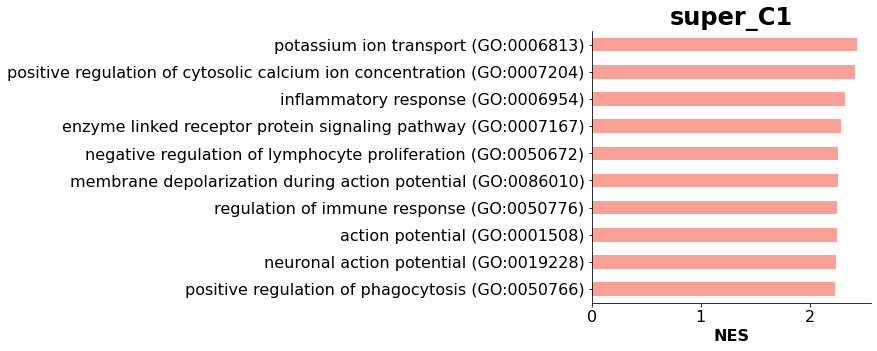

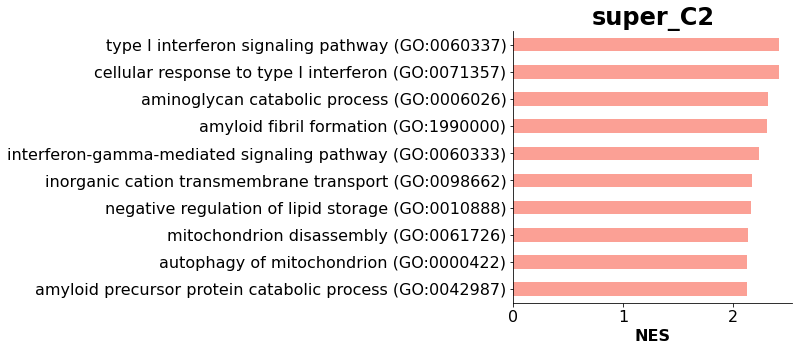

In [319]:
for c in result_gsea.keys():
    barplot(result_gsea[c].res2d,
            column='NES',
            x='Term',
            top_term=10,
            figsize=(5, 5),
            title=c,
            xticklabels_rot=45)

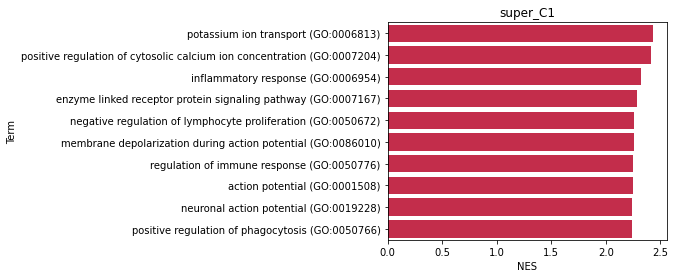

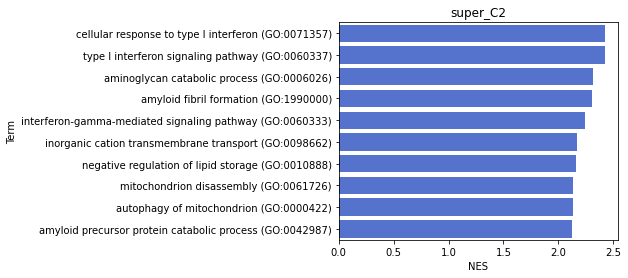

In [396]:
tmp_c = {'super_C1': 'crimson', 'super_C2': 'royalblue'}
for c in result_gsea.keys():
    plt.figure(figsize=(5, 4))
    tmp = result_gsea[c].res2d.sort_values(by='NES', ascending=False)[:10]
    sns.barplot(x='NES', y='Term', data=tmp, color=tmp_c[c])
    plt.title(c)
    fig = plt.gcf()
    fig.savefig(panel_home + c + '_top10.pdf', transparent=True)
    plt.show()

In [307]:
cluster_go_logfdr['difference'] = cluster_go_logfdr['super_C2'] - cluster_go_logfdr['super_C1']

In [321]:
cluster_go_nes['difference'] = cluster_go_nes['super_C2'] - cluster_go_nes['super_C1']

In [323]:
cluster_go_nes.sort_values(by='difference', ascending=False)

,super_C1,super_C2,difference
multivesicular body assembly (GO:0036258),-1.547616,1.106440,2.654056
macroautophagy (GO:0016236),-0.838789,1.720603,2.559392
positive regulation of protein exit from endoplasmic reticulum (GO:0070863),-1.294032,1.242499,2.536531
ubiquitin-dependent ERAD pathway (GO:0030433),-0.599413,1.880098,2.479511
regulation of viral life cycle (GO:1903900),-1.069411,1.380190,2.449601
...,...,...,...
cellular response to alkaloid (GO:0071312),0.989703,-1.507110,-2.496813
positive regulation of interleukin-10 production (GO:0032733),1.704692,-0.807297,-2.511989
lymphocyte proliferation (GO:0046651),1.346701,-1.176983,-2.523684
cellular response to inorganic substance (GO:0071241),0.920724,-1.642436,-2.563160


In [287]:
selected_pathway = list(cluster_go_logfdr.sort_values(by='super_C2', ascending=False)[:25].index)
selected_pathway.extend(list(cluster_go_logfdr.sort_values(by='super_C1', ascending=False)[:25].index))

In [288]:
selected_pathway = list(set(selected_pathway))

(-0.1, 4.1)

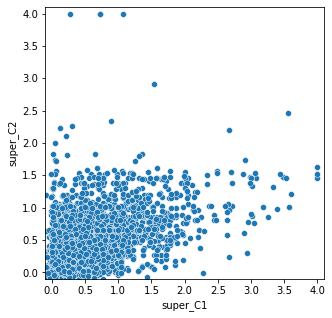

In [289]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='super_C1', y='super_C2', data=cluster_go_logfdr)
plt.xlim(-.1, 4.1)
plt.ylim(-.1, 4.1)

<AxesSubplot:xlabel='super_C1', ylabel='super_C2'>

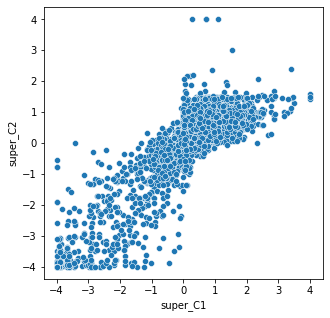

In [324]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='super_C1', y='super_C2', data=cluster_go_logfdr)

In [377]:
def pathway_bubble(merged_signP, merged_nes, c1, c2, save_path=None):
    
    # add NR difference
    merged_signP['NES_diff'] = merged_nes.loc[merged_signP.index, c2] - merged_nes.loc[merged_signP.index, c1]
    merged_signP['signP_diff'] = merged_signP[c2] - merged_signP[c1]
    
    f, ax = plt.subplots(figsize=(7, 6))
    tmp = merged_signP[merged_signP[c2] > 0]
    tmp = tmp[tmp[c1] > 0]
    cax = ax.scatter(x=tmp[c1], y=tmp[c2],
                     # s=abs(tmp['signP_diff']) * 100,
                     linewidths=0.5, edgecolors='k',
                     c=tmp['NES_diff'], cmap=plt.cm.Spectral, vmin=-1, vmax=1, alpha=0.8)

    for g in tmp[tmp['signP_diff'] >= 2].index:
            plt.text(x=tmp.loc[g, c1] + 0.1, y=tmp.loc[g, c2] + 0.1, s=g, fontsize=12, c='b')
    for g in tmp[tmp['signP_diff'] <= -2].index:
            plt.text(x=tmp.loc[g, c1] + 0.1, y=tmp.loc[g, c2] + 0.1, s=g, fontsize=12, c='r')


    plt.ylim(0., 4.5)
    plt.xlim(0., 4.5)
    plt.xlabel('signed(-log10FDR) of ' + c1)
    plt.ylabel('signed(-log10FDR) of ' + c2)
    ax.axline((1, 1), slope=1, ls='--', c='k')
    plt.axvline(x=2., ls='--', c='k')
    plt.axhline(y=2., ls='--', c='k')
    plt.yticks(rotation=90)
    plt.colorbar(cax)
    fig = plt.gcf()
    
    if save_path is not None:
        fig.savefig(panel_home + save_path + '.png', dpi=300, transparent=True)
        fig.savefig(panel_home + save_path + '.pdf', transparent=True)
    
    return

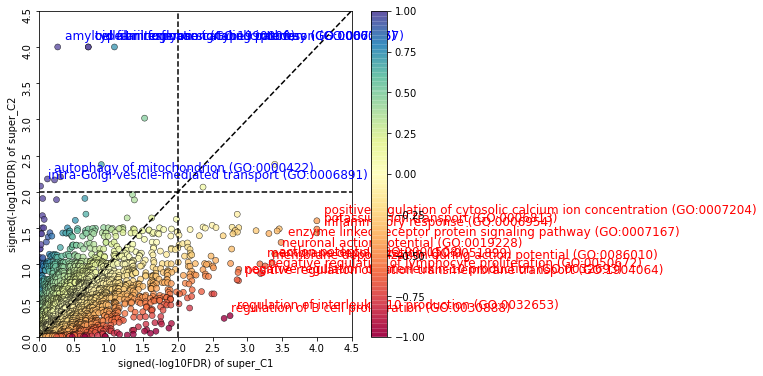

In [378]:
pathway_bubble(merged_signP=cluster_go_logfdr.loc[cluster_go_nes.index, :], merged_nes=cluster_go_nes,
               c1='super_C1', c2='super_C2', save_path='new_super_780_GO')

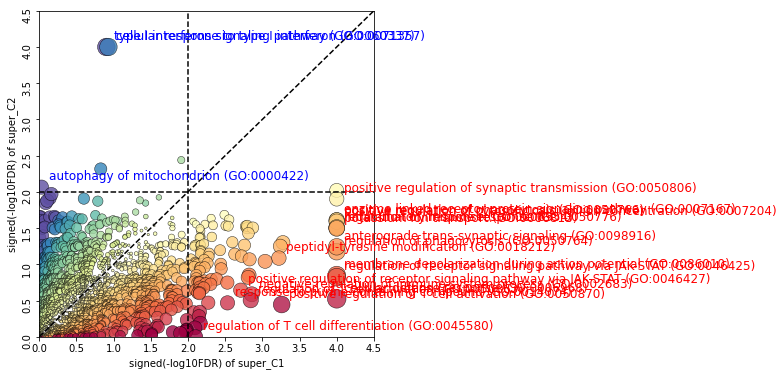

In [493]:
pathway_bubble(merged_signP=cluster_go_logfdr.loc[cluster_go_nes.index, :], merged_nes=cluster_go_nes,
               c1='super_C1', c2='super_C2', save_path='super_780_GO')

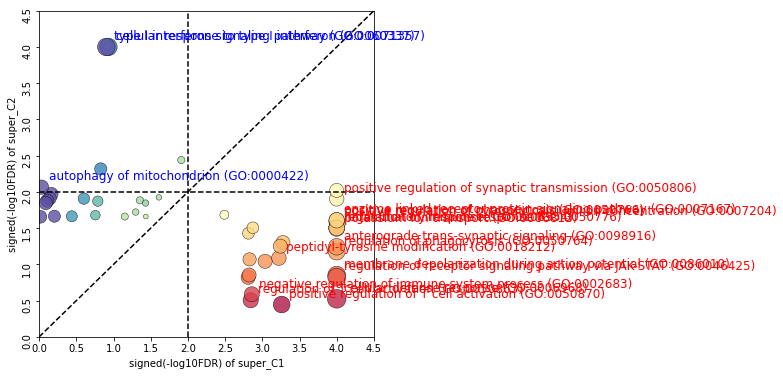

In [503]:
pathway_bubble(merged_signP=cluster_go_logfdr.loc[selected_pathway, :], merged_nes=cluster_go_nes.loc[selected_pathway, :],
               c1='super_C1', c2='super_C2', save_path='selected_super_780_GO')

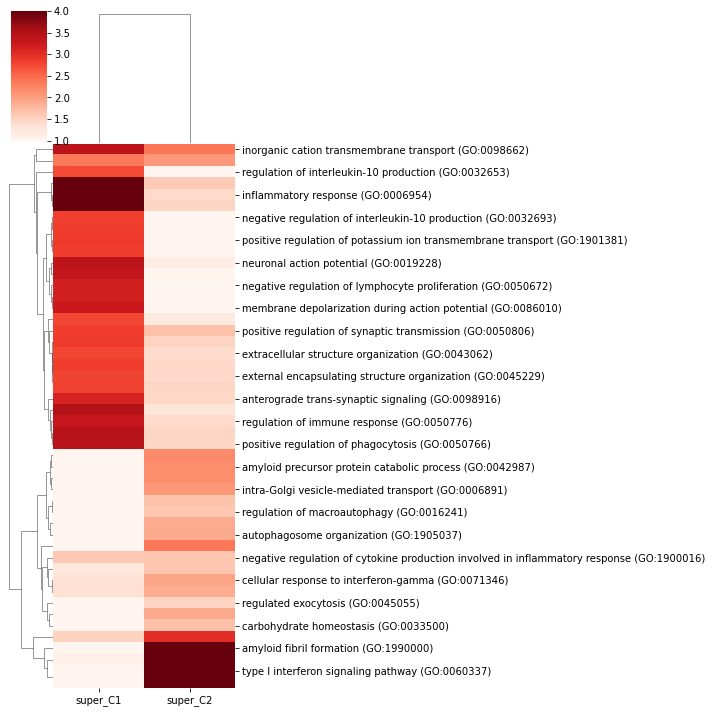

In [329]:
sns.clustermap(cluster_go_logfdr.loc[selected_pathway, ['super_C1', 'super_C2']], cmap='Reds', vmin=1., vmax=4)

In [360]:
pd.crosstab(cluster_super['cluster'], cluster_super['moa']).T.sort_values(by='super_C2', ascending=False)[:10]

cluster,super_C1,super_C2
moa,,
HDAC inhibitor,0,21
Topoisomerase inhibitor,2,15
MTOR inhibitor,2,12
EGFR inhibitor,4,11
MEK inhibitor,0,11
RAF inhibitor,0,7
KIT inhibitor,0,7
HMGCR inhibitor,0,7
PI3K inhibitor,2,6


In [361]:
pd.crosstab(cluster_super['cluster'], cluster_super['moa']).T.sort_values(by='super_C1', ascending=False)[:10]

cluster,super_C1,super_C2
moa,,
CDK inhibitor,6,4
JAK inhibitor,5,4
EGFR inhibitor,4,11
Glucocorticoid receptor agonist,4,0
PLK inhibitor,4,2
BCL inhibitor,3,1
Cyclooxygenase inhibitor,3,3
Histamine receptor antagonist,3,0
PKC inhibitor,3,0


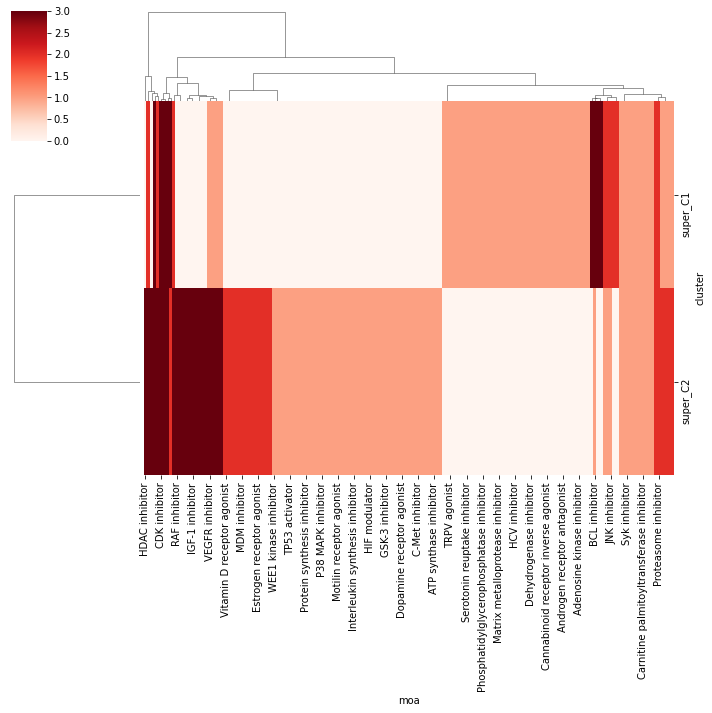

In [403]:
sns.clustermap(pd.crosstab(cluster_super['cluster'], cluster_super['moa']),
               method='ward',
               cmap='Reds', vmin=0, vmax=3)

In [363]:
cluster_super['moa'].unique().shape

(166,)

In [331]:
cluster_super[cluster_super['moa'] == 'CDK inhibitor']

,cluster,moa
cmap_name,,
AT-7519,super_C1,CDK inhibitor
BMS-387032,super_C1,CDK inhibitor
CGP-60474,super_C1,CDK inhibitor
PHA-793887,super_C2,CDK inhibitor
PHA-848125,super_C2,CDK inhibitor
alvocidib,super_C1,CDK inhibitor
aminopurvalanol-a,super_C1,CDK inhibitor
dinaciclib,super_C1,CDK inhibitor
palbociclib,super_C2,CDK inhibitor


In [332]:
cluster_super['CXCL10'] = con_bing_matrix.T['CXCL10']
cluster_super['HLA-A'] = con_bing_matrix.T['HLA-A']
cluster_super['IFI27'] = con_bing_matrix.T['IFI27']
cluster_super['TAP1'] = con_bing_matrix.T['TAP1']
cluster_super['B2M'] = con_bing_matrix.T['B2M']

<AxesSubplot:xlabel='cluster', ylabel='CXCL10'>

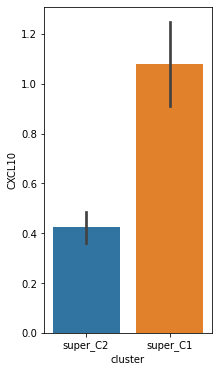

In [334]:
plt.figure(figsize=(3, 6))
sns.barplot(x='cluster', y='CXCL10', data=cluster_super)

<AxesSubplot:xlabel='cluster', ylabel='B2M'>

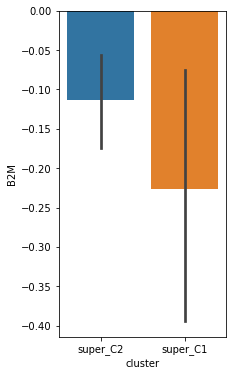

In [335]:
plt.figure(figsize=(3, 6))
sns.barplot(x='cluster', y='B2M', data=cluster_super)

<AxesSubplot:xlabel='cluster', ylabel='TAP1'>

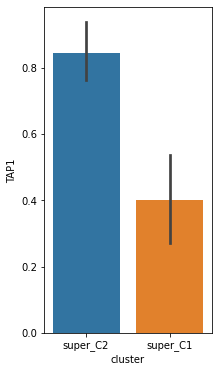

In [336]:
plt.figure(figsize=(3, 6))
sns.barplot(x='cluster', y='TAP1', data=cluster_super)

<AxesSubplot:xlabel='cluster', ylabel='HLA-A'>

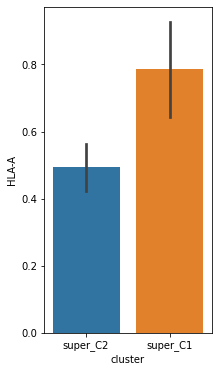

In [337]:
plt.figure(figsize=(3, 6))
sns.barplot(x='cluster', y='HLA-A', data=cluster_super)

<AxesSubplot:xlabel='cluster', ylabel='IFI27'>

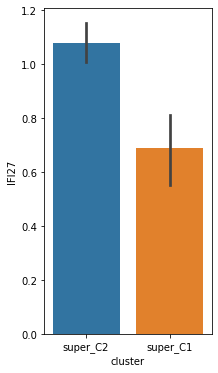

In [338]:
plt.figure(figsize=(3, 6))
sns.barplot(x='cluster', y='IFI27', data=cluster_super)

In [320]:
cluster_im_gsea = {}
for c in con_bing_cluster.columns:
    rnk = con_bing_cluster.sort_values(by=c, ascending=False)[c]
    pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + 'gene_sets/WolfEtAl_71_Symbols.gmt',
                         processes=20,
                         permutation_num=1000,
                         outdir=None, seed=0, min_size=10, max_size=2000)
    tmp_result = pre_res.res2d
    cluster_im_gsea[c] = tmp_result


<ipython-input-320-7ff4743d1202>:4: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + 'gene_sets/WolfEtAl_71_Symbols.gmt',
2023-06-06 18:10:34,614 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-06-06 18:10:35,216 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [350]:
cluster_im_nes = pd.concat([df(cluster_im_gsea[k].set_index('Term')['NES']).rename(columns={'NES': k}) for k in cluster_im_gsea.keys()], axis=1)
cluster_im_fdr = pd.concat([df(cluster_im_gsea[k].set_index('Term')['FDR q-val']).rename(columns={'FDR q-val': k}) for k in cluster_im_gsea.keys()], axis=1)

(0.0, 3.0)

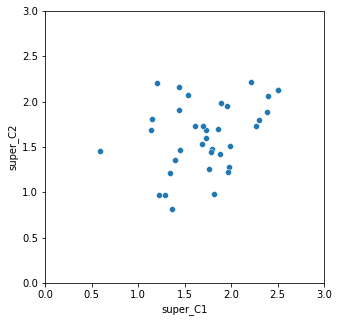

In [340]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='super_C1', y='super_C2', data=cluster_im_nes)
plt.xlim(0, 3)
plt.ylim(0, 3)

In [341]:
immunity_class = pd.read_csv(data_home + 'immuneSig/signature_class.csv',
                             header=0, index_col=0, sep=',')
immunity_class

,class
signatures,
MHC1_21978456,Antigen Presentation
MHC2_21978456,Antigen Presentation
MHC.I_19272155,Antigen Presentation
MHC.II_19272155,Antigen Presentation
PD1_data,Check Point
...,...
GRANS_PCA_16704732,Other
Buck14_score,Other
Module11_Prolif_score,Proliferation


In [351]:
cluser_im_nes = cluster_im_nes.astype(float)

In [352]:
cluster_im_nes['class'] = immunity_class['class']

In [344]:
cluster_im_nes

,super_C1,super_C2,class
Module11_Prolif_score,-4.40525,-3.89243,Proliferation
CHANG_CORE_SERUM_RESPONSE_UP,-3.54308,-3.39669,Proliferation
KEGG_HEMATOPOIETIC_CELL_LINEAGE,2.50648,2.12549,NaN
CSF1_response,2.50042,2.12999,TAM
Immune_cell_Cluster_21214954,2.40113,2.06339,Leukocyte
Module5_TcellBcell_score,2.39029,1.88275,Leukocyte
Module4_TcellBcell_score,2.29788,1.79475,Leukocyte
LCK_19272155,2.2662,1.73501,Leukocyte
HER2_Immune_PCA_18006808,2.20883,2.21733,Other
TAMsurr_TcClassII_ratio,1.98746,1.5148,TAM


In [356]:
cluster_im_nes_class = cluster_im_nes.groupby('class').mean(numeric_only=False)

In [357]:
cluster_im_nes_class

,super_C1,super_C2
class,,
Antigen Presentation,1.445894,1.462957
B cell,1.707182,1.614302
Cytokine,1.564047,1.160467
Cytotoxic T cell,1.789320,1.428347
DC cells,1.695121,1.735155
IFN Signaling,1.286282,1.905399
Leukocyte,1.610439,1.253808
Other,1.705829,1.552463
Proliferation,-3.299085,-3.132797


(1.0, 2.2)

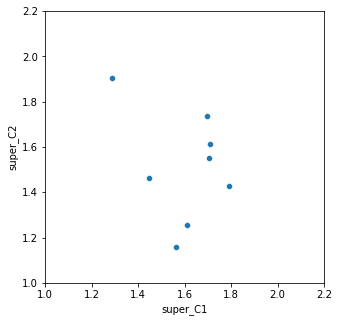

In [358]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='super_C1', y='super_C2', data=cluster_im_nes_class)
plt.xlim(1, 2.2)
plt.ylim(1, 2.2)

# Immune signature on all 780 compounds

In [310]:
im_con_gsea = {}
for c in con_bing_matrix.columns:
    rnk = df(con_bing_matrix[c]).sort_values(by=c, ascending=False)[c]
    pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + 'gene_sets/WolfEtAl_71_Symbols.gmt',
                         processes=20,
                         permutation_num=100,
                         outdir=None, seed=0, min_size=10, max_size=2000)
    tmp_im_result = pre_res.res2d
    im_con_gsea[c] = tmp_im_result

In [311]:
im_con_nes = pd.concat([df(im_con_gsea[k]['nes']).rename(columns={'nes': k}) for k in im_con_gsea.keys()], axis=1)
im_con_fdr = pd.concat([df(im_con_gsea[k]['fdr']).rename(columns={'fdr': k}) for k in im_con_gsea.keys()], axis=1)

In [317]:
im_con_nes_class = im_con_nes.copy()
im_con_nes_class = im_con_nes_class.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any')
im_con_nes_class['class'] = immunity_class['class']
im_con_nes_class = im_con_nes_class.groupby('class').mean()

In [318]:
distanceMatrix = pdist(im_con_nes_class.T, metric='correlation')

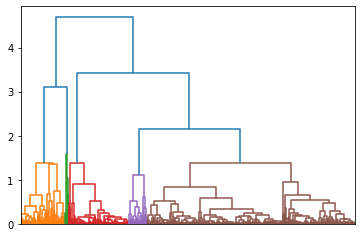

In [325]:
dend_im = dendrogram(linkage(distanceMatrix, method='ward'), 
                  color_threshold=2,
                  no_labels=True,
                  leaf_font_size=1)

In [333]:
cluster_im_size = {}
for c in set(dend_im['color_list']):
    print(c)
    print(len([i for i in dend_im['color_list'] if i == c]) + 1)
    cluster_im_size[c] = len([i for i in dend_im['color_list'] if i == c]) + 1

C2
8
C1
104
C3
140
C5
485
C4
43
C0
5


In [328]:
# assign super cluster
cluster_im = df(index=con_bing_matrix.columns, columns=['cluster'])
tmp_ind = 0
for i in range(5):
    tmp_c = i + 1
    tmp_c_name = 'C' + str(tmp_c)

    for j in range(cluster_im_size[tmp_c_name]):
        cluster_im.at[cluster_im.index[dend_im['leaves'][tmp_ind + j]], 'cluster'] = 'IM_' + tmp_c_name
    tmp_ind = tmp_ind + cluster_im_size[tmp_c_name]

In [330]:
cluster_im['moa'] = compound_info['moa']

In [331]:
cluster_im[cluster_im['moa'] == 'MEK inhibitor']

,cluster,moa
cmap_name,,
AS-703026,IM_C5,MEK inhibitor
PD-0325901,IM_C5,MEK inhibitor
PD-184352,IM_C5,MEK inhibitor
PD-198306,IM_C5,MEK inhibitor
PD-98059,IM_C5,MEK inhibitor
Ro-4987655,IM_C5,MEK inhibitor
TAK-733,IM_C5,MEK inhibitor
U-0126,IM_C5,MEK inhibitor
refametinib,IM_C5,MEK inhibitor


In [332]:
cluster_im.loc['PF-03758309', :]

cluster                             IM_C1
moa        P21 activated kinase inhibitor
Name: PF-03758309, dtype: object

In [334]:
cluster_im[cluster_im['moa'] == 'HDAC inhibitor']

,cluster,moa
cmap_name,,
ACY-1215,IM_C5,HDAC inhibitor
HDAC3-selective,IM_C4,HDAC inhibitor
ISOX,IM_C3,HDAC inhibitor
JNJ-26481585,IM_C5,HDAC inhibitor
Merck60,IM_C5,HDAC inhibitor
NCH-51,IM_C5,HDAC inhibitor
PCI-24781,IM_C5,HDAC inhibitor
SB-939,IM_C5,HDAC inhibitor
WT-171,IM_C5,HDAC inhibitor


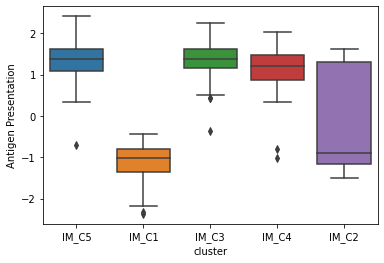

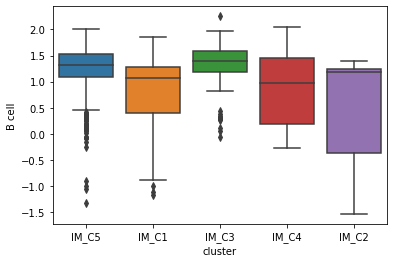

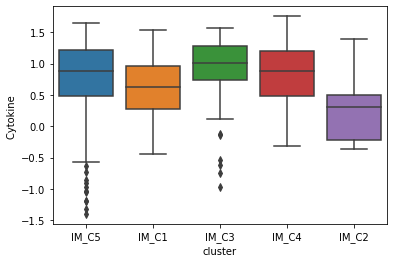

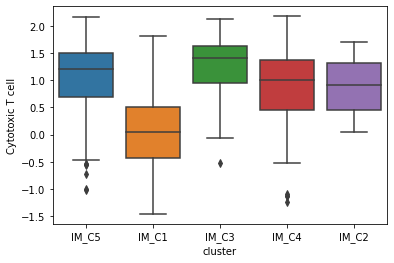

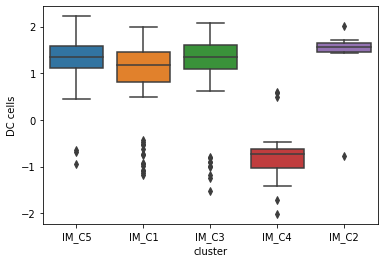

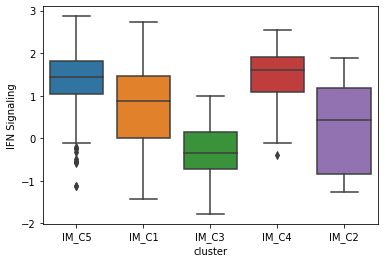

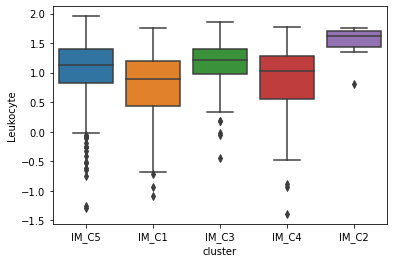

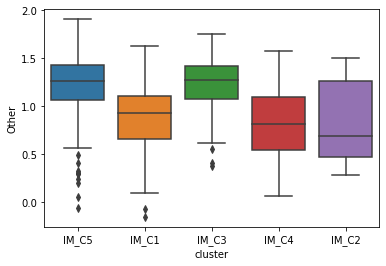

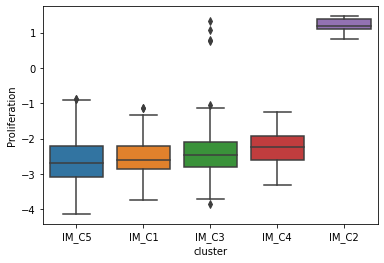

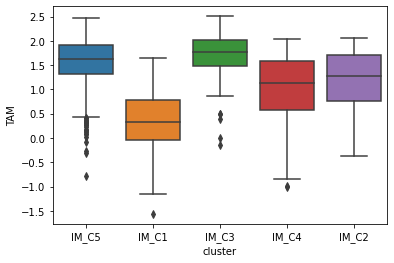

In [336]:
for c in im_con_nes_class.index:
    tmp_c = df(im_con_nes_class.T[c])
    tmp_c['cluster'] = cluster_im['cluster']
    sns.boxplot(x='cluster', y=c, data=tmp_c)
    plt.show()

In [337]:
pd.crosstab(cluster_im['cluster'], cluster_im['moa'])

moa,11-beta-HSD1 inhibitor,ALK inhibitor,AMPK activator,AMPK inhibitor,APEX inhibitor,ARFGAP inhibitor,ATP citrase lyase inhibitor,ATP synthase inhibitor,AXL kinase inhibitor,Abl kinase inhibitor,...,Thrombopoietin receptor agonist,Thymidylate synthase inhibitor,Topoisomerase inhibitor,Tricyclic antidepressant,Tubulin inhibitor,Tyrosine kinase inhibitor,Ubiquitin specific protease inhibitor,VEGFR inhibitor,Vitamin D receptor agonist,WEE1 kinase inhibitor
cluster,,,,,,,,,,,,,,,,,,,,,
IM_C1,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
IM_C2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
IM_C3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
IM_C4,1,1,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
IM_C5,0,3,0,0,1,1,1,0,0,3,...,0,2,17,1,1,0,0,4,1,1


In [398]:
for c in cluster_im['cluster'].unique():
    print(c)
    print(cluster_im[cluster_im['cluster'] == c]['moa'].value_counts())

IM_C5
HDAC inhibitor                                18
Topoisomerase inhibitor                       17
MTOR inhibitor                                12
MEK inhibitor                                 11
EGFR inhibitor                                11
                                              ..
DNA binding agent                              1
Neural stem cell inducer                       1
FtsZ inhibitor                                 1
MAP kinase inhibitor                           1
Receptor tyrosine protein kinase inhibitor     1
Name: moa, Length: 110, dtype: int64
IM_C1
JAK inhibitor                                 3
Purinergic receptor antagonist                2
HMGCR inhibitor                               2
Histone lysine demethylase inhibitor          2
Androgen receptor agonist                     2
Exportin antagonist                           2
PLK inhibitor                                 2
Dopamine receptor antagonist                  2
Proteasome inhibitor        